# Let's Build a Quant Trading Strategy

In [255]:
# signal = model(x)
# orders = strategy(signal)
# execute(orders)

In [256]:
# In the last video, we built a model that predicts what the log return will be eight hours from now.

In [257]:
# This video is about strategy development based on our model

In [258]:
# I tried to make it accessible even if you haven't watched part 1.

In [259]:
# I changed the model as it not predicts 12 hours ahead and not 8h. Simple reason is to increase our time horizon so the fees don't eat as much into our profits.

In [260]:
# The model uses lag 1, lag 2 and lag 3. We will go into more detail about the model.

### type of strategies 

In [261]:
# 1 Maker strategies => they are providing liquidity => adding liquidity to a market and aim to be compensated for it
# 2 Taker strategies => they taking away liquidity => market orders that consume liquidity => what we are going to focus on

In [262]:
# Key Questions for our taking strategy

# 1. Entry/exit timing?
# 2. Trade Size
# 3. Use Leverage?
# 4. Use take-profit orders?
# 5. Use stop-loss orders?



In [263]:
## the key goal is we want to create a strategy that increases profits from the model's edge

### import the libraries

In [264]:
# Data and analysis libraries
import polars as pl                         # Fast dataframes for financial data
import numpy as np                          # Numerical computing library
from datetime import datetime, timedelta    # Date and time operations
import random


# Machine learning libraries  
import torch                                # PyTorch framework
import torch.nn as nn                       # Neural network modules
import torch.optim as optim                 # Optimization algorithms
import research                             # Model building and training utilities


# Visualization and 
import altair as alt                        # Interactive visualization library

# data sources
import binance                              # Binance market data utilities


### research parameters

In [265]:
sym = 'BTCUSDT'
time_interval = '12h'
download_window = 7 * 4 * 7 # roughly 6 months
forecast_horizon = 1
test_size = 0.25

### load the model 

In [266]:
import models
model = models.LinearModel(3)
# security alert 
model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model.eval()

LinearModel(
  (linear): Linear(in_features=3, out_features=1, bias=True)
)

### interpreted as a mean reversion model

In [267]:
series = [-0.014000, 0.011399, -0.012212, 0.01997, -0.01442, 0.01227]
mu = np.mean(series)
mean_reversion_df = pl.DataFrame({'log_return': series, 'mean': mu})
mean_reversion_df

shape: (6, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ log_return ‚îÜ mean     ‚îÇ
‚îÇ ---        ‚îÜ ---      ‚îÇ
‚îÇ f64        ‚îÜ f64      ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ -0.014     ‚îÜ 0.000501 ‚îÇ
‚îÇ 0.011399   ‚îÜ 0.000501 ‚îÇ
‚îÇ -0.012212  ‚îÜ 0.000501 ‚îÇ
‚îÇ 0.01997    ‚îÜ 0.000501 ‚îÇ
‚îÇ -0.01442   ‚îÜ 0.000501 ‚îÇ
‚îÇ 0.01227    ‚îÜ 0.000501 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

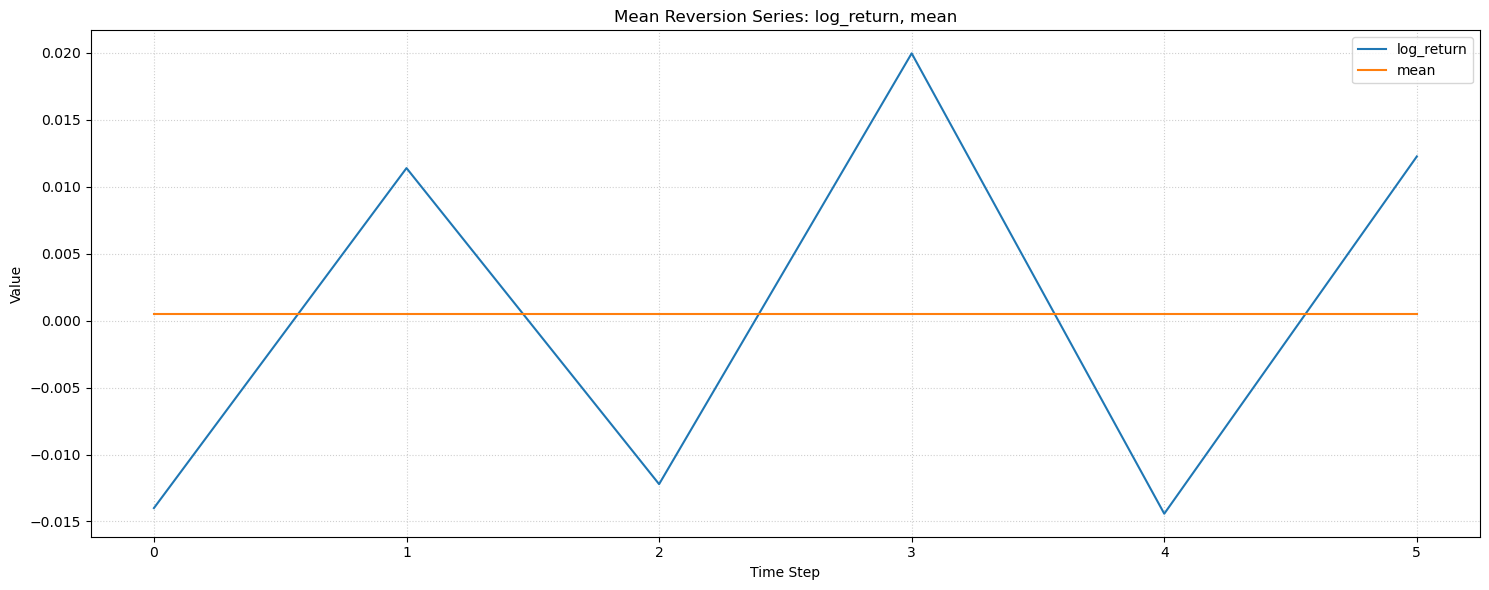

In [268]:
research.plot_multiple_lines(mean_reversion_df, ['log_return','mean'], 'Mean Reversion')

### model parameters

In [269]:
research.print_model_params(model)

linear.weight:
[[-0.10395038 -0.06726477  0.02827305]]
linear.bias:
[0.00067121]


### üß© Interpretation

- **w‚ÇÅ = ‚Äì0.10** ‚Üí The last observation (*y‚Çú‚Çã‚ÇÅ*) has a slight negative relationship:  
  if it went up by 1, the current value tends to go down by about 0.10 (all else equal).

- **w‚ÇÇ = ‚Äì0.07** ‚Üí The value two steps ago also has a small negative influence.

- **w‚ÇÉ = +0.03** ‚Üí The value three steps ago has a small positive effect.

model = mean-reverting dynamics ‚Äî recent values push future ones in the opposite direction a little, with diminishing influence up to three lags

### interpretability of linear model

In [270]:
def linear_model(x):
    w, b = -0.09911217, 0.00059838
    return w * x + b

linear_model(-0.015) 

0.00208506255

In [271]:
linear_model(0.02) 

-0.0013838634

In [272]:
linear_model(0.000002)

0.00059818177566

In [273]:
linear_model(0.0)

0.00059838

### interpretability of a neural network

In [274]:
def nn_model(x):
    x = torch.tensor([x])
    W = torch.tensor([0.08035, -0.01478, -0.03523,  0.06777,  0.03789,  0.0013991, -0.13303,  0.8045])
    b = torch.tensor([0.16421])
    return torch.tanh(torch.sum(x * W) + b)

nn_model(-0.015)

tensor([0.1509])

In [275]:
# no interability
nn_model(0.02)

tensor([0.1785])

In [276]:
nn_model(0.0)

tensor([0.1627])

In [277]:
# not disparaging neural networks as my background is neural networks 
# but for trading, neural networks can increase your expected value but at the expense of complexity
# linear models are not sensitive to noise, they are interpretible, less prone to overfit (generalization)

## Strategy Development!

### load time series data

In [278]:
binance.download_trades(sym, download_window)

In [279]:
ts = research.load_ohlc_timeseries(sym, time_interval)
ts

Loading BTCUSDT: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 346/346 [00:31<00:00, 10.84file/s]


shape: (692, 5)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ datetime            ‚îÜ open     ‚îÜ high     ‚îÜ low      ‚îÜ close    ‚îÇ
‚îÇ ---                 ‚îÜ ---      ‚îÜ ---      ‚îÜ ---      ‚îÜ ---      ‚îÇ
‚îÇ datetime[Œºs]        ‚îÜ f64      ‚îÜ f64      ‚îÜ f64      ‚îÜ f64      ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2024-10-29 00:00:00 ‚îÜ 69939.9  ‚îÜ 71607.0  ‚îÜ 69733.0  ‚îÜ 71440.1  ‚îÇ
‚îÇ 2024-10-29 12:00:00 ‚îÜ 71440.0  ‚îÜ 73660.0  ‚îÜ 70900.0  ‚îÜ 72739.5  ‚îÇ
‚îÇ 2024-10-30 00:00:00 ‚îÜ 72739.5  ‚îÜ 72797.4  ‚îÜ 71931.1  ‚îÜ 71995.0  ‚îÇ
‚îÇ 2024-10-30 12:00:00 ‚îÜ 71994.9  ‚îÜ 72984.9  ‚îÜ 71444.2  ‚îÜ 72349.0  ‚îÇ
‚îÇ 2024-10-31 00:00:00 ‚îÜ 72349.0  ‚îÜ 72720.3  ‚îÜ 72030.5  ‚îÜ 72213.3  ‚îÇ
‚îÇ ‚Ä¶                   ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÇ
‚îÇ 2025-10-07 12:00:00 ‚îÜ 124397.1 ‚îÜ 125098.0 ‚îÜ 120516.0 ‚îÜ 121286.5 ‚îÇ
‚îÇ 2025-10-08 00:00:00 ‚îÜ 121286.6 ‚îÜ 123150.0 ‚îÜ 121005.3 ‚îÜ 122825.7 ‚îÇ
‚îÇ 2025-10-08 12:00:00 ‚îÜ 122825.8 ‚îÜ 124170.6 ‚îÜ 121607.8 ‚îÜ 123237.5 ‚îÇ
‚îÇ 2025-10-09 00:00:00 ‚îÜ 123237.4 ‚îÜ 123279.7 ‚îÜ 121081.5 ‚îÜ 122672.9 ‚îÇ
‚îÇ 2025-10-09 12:00:00 ‚îÜ 122673.0 ‚îÜ 123740.1 ‚îÜ 119572.8 ‚îÜ 121579.3 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

### add log return target and its auto-regressive lags

In [280]:
ts = research.add_log_return_features(ts, 'close', forecast_horizon, max_no_lags=3)
ts

shape: (692, 9)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ datetime   ‚îÜ open     ‚îÜ high     ‚îÜ low      ‚îÜ ‚Ä¶ ‚îÜ close_log_ ‚îÜ close_log ‚îÜ close_log ‚îÜ close_log ‚îÇ
‚îÇ ---        ‚îÜ ---      ‚îÜ ---      ‚îÜ ---      ‚îÜ   ‚îÜ return     ‚îÜ _return_l ‚îÜ _return_l ‚îÜ _return_l ‚îÇ
‚îÇ datetime[Œº ‚îÜ f64      ‚îÜ f64      ‚îÜ f64      ‚îÜ   ‚îÜ ---        ‚îÜ ag_1      ‚îÜ ag_2      ‚îÜ ag_3      ‚îÇ
‚îÇ s]         ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ f64        ‚îÜ ---       ‚îÜ ---       ‚îÜ ---       ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ f64       ‚îÜ f64       ‚îÜ f64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2024-10-29 ‚îÜ 69939.9  ‚îÜ 71607.0  ‚îÜ 69733.0  ‚îÜ ‚Ä¶ ‚îÜ null       ‚îÜ null      ‚îÜ null      ‚îÜ null      ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2024-10-29 ‚îÜ 71440.0  ‚îÜ 73660.0  ‚îÜ 70900.0  ‚îÜ ‚Ä¶ ‚îÜ 0.018025   ‚îÜ null      ‚îÜ null      ‚îÜ null      ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2024-10-30 ‚îÜ 72739.5  ‚îÜ 72797.4  ‚îÜ 71931.1  ‚îÜ ‚Ä¶ ‚îÜ -0.010288  ‚îÜ 0.018025  ‚îÜ null      ‚îÜ null      ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2024-10-30 ‚îÜ 71994.9  ‚îÜ 72984.9  ‚îÜ 71444.2  ‚îÜ ‚Ä¶ ‚îÜ 0.004905   ‚îÜ -0.010288 ‚îÜ 0.018025  ‚îÜ null      ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2024-10-31 ‚îÜ 72349.0  ‚îÜ 72720.3  ‚îÜ 72030.5  ‚îÜ ‚Ä¶ ‚îÜ -0.001877  ‚îÜ 0.004905  ‚îÜ -0.010288 ‚îÜ 0.018025  ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶ ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÇ
‚îÇ 2025-10-07 ‚îÜ 124397.1 ‚îÜ 125098.0 ‚îÜ 120516.0 ‚îÜ ‚Ä¶ ‚îÜ -0.025324  ‚îÜ -0.001858 ‚îÜ 0.003757  ‚îÜ 0.005933  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-08 ‚îÜ 121286.6 ‚îÜ 123150.0 ‚îÜ 121005.3 ‚îÜ ‚Ä¶ ‚îÜ 0.012611   ‚îÜ -0.025324 ‚îÜ -0.001858 ‚îÜ 0.003757  ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-08 ‚îÜ 122825.8 ‚îÜ 124170.6 ‚îÜ 121607.8 ‚îÜ ‚Ä¶ ‚îÜ 0.003347   ‚îÜ 0.012611  ‚îÜ -0.025324 ‚îÜ -0.001858 ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-09 ‚îÜ 123237.4 ‚îÜ 123279.7 ‚îÜ 121081.5 ‚îÜ ‚Ä¶ ‚îÜ -0.004592  ‚îÜ 0.003347  ‚îÜ 0.012611  ‚îÜ -0.025324 ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-09 ‚îÜ 122673.0 ‚îÜ 123740.1 ‚îÜ 119572.8 ‚îÜ ‚Ä¶ ‚îÜ -0.008955  ‚îÜ -0.004592 ‚îÜ 0.003347  ‚îÜ 0.012611  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ

### use most recent data to develop the strategy

In [281]:
_, test_trades = research.timeseries_split(ts, test_size)
test_trades

shape: (173, 9)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ datetime   ‚îÜ open     ‚îÜ high     ‚îÜ low      ‚îÜ ‚Ä¶ ‚îÜ close_log_ ‚îÜ close_log ‚îÜ close_log ‚îÜ close_log ‚îÇ
‚îÇ ---        ‚îÜ ---      ‚îÜ ---      ‚îÜ ---      ‚îÜ   ‚îÜ return     ‚îÜ _return_l ‚îÜ _return_l ‚îÜ _return_l ‚îÇ
‚îÇ datetime[Œº ‚îÜ f64      ‚îÜ f64      ‚îÜ f64      ‚îÜ   ‚îÜ ---        ‚îÜ ag_1      ‚îÜ ag_2      ‚îÜ ag_3      ‚îÇ
‚îÇ s]         ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ f64        ‚îÜ ---       ‚îÜ ---       ‚îÜ ---       ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ f64       ‚îÜ f64       ‚îÜ f64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2025-07-15 ‚îÜ 117110.4 ‚îÜ 118499.8 ‚îÜ 115678.1 ‚îÜ ‚Ä¶ ‚îÜ 0.005349   ‚îÜ -0.022844 ‚îÜ -0.013743 ‚îÜ 0.020259  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-16 ‚îÜ 117738.6 ‚îÜ 119299.9 ‚îÜ 117017.1 ‚îÜ ‚Ä¶ ‚îÜ 0.008597   ‚îÜ 0.005349  ‚îÜ -0.022844 ‚îÜ -0.013743 ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-16 ‚îÜ 118755.1 ‚îÜ 120100.0 ‚îÜ 118156.0 ‚îÜ ‚Ä¶ ‚îÜ -0.001385  ‚îÜ 0.008597  ‚îÜ 0.005349  ‚îÜ -0.022844 ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-17 ‚îÜ 118590.7 ‚îÜ 119216.4 ‚îÜ 117663.6 ‚îÜ ‚Ä¶ ‚îÜ -0.005257  ‚îÜ -0.001385 ‚îÜ 0.008597  ‚îÜ 0.005349  ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-17 ‚îÜ 117968.8 ‚îÜ 120951.5 ‚îÜ 117412.8 ‚îÜ ‚Ä¶ ‚îÜ 0.010185   ‚îÜ -0.005257 ‚îÜ -0.001385 ‚îÜ 0.008597  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶ ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÇ
‚îÇ 2025-10-07 ‚îÜ 124397.1 ‚îÜ 125098.0 ‚îÜ 120516.0 ‚îÜ ‚Ä¶ ‚îÜ -0.025324  ‚îÜ -0.001858 ‚îÜ 0.003757  ‚îÜ 0.005933  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-08 ‚îÜ 121286.6 ‚îÜ 123150.0 ‚îÜ 121005.3 ‚îÜ ‚Ä¶ ‚îÜ 0.012611   ‚îÜ -0.025324 ‚îÜ -0.001858 ‚îÜ 0.003757  ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-08 ‚îÜ 122825.8 ‚îÜ 124170.6 ‚îÜ 121607.8 ‚îÜ ‚Ä¶ ‚îÜ 0.003347   ‚îÜ 0.012611  ‚îÜ -0.025324 ‚îÜ -0.001858 ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-09 ‚îÜ 123237.4 ‚îÜ 123279.7 ‚îÜ 121081.5 ‚îÜ ‚Ä¶ ‚îÜ -0.004592  ‚îÜ 0.003347  ‚îÜ 0.012611  ‚îÜ -0.025324 ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-09 ‚îÜ 122673.0 ‚îÜ 123740.1 ‚îÜ 119572.8 ‚îÜ ‚Ä¶ ‚îÜ -0.008955  ‚îÜ -0.004592 ‚îÜ 0.003347  ‚îÜ 0.012611  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ

## Strategy Decision #1. What's our entry and exit signal?

In [282]:
# q1: when do we get in? entry signal
# q2: when do we get out? exit signal

In [283]:
# 1. Time Based 
# 2. Predicate Based 

In [284]:
# 00:00 -> trade to create a BTCUSDT position based on our prediction
# 12:00 -> trade to close the existing BTCUSDT position, trade to enter a new position on the current log return (00:00 -> 12:00) prediction
# 00:00 -> trade to close the existing BTCUSDT pos, trade to enter a new position on the current log return (12:00 -> 00:00) prediction

In [285]:
test_trades

shape: (173, 9)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ datetime   ‚îÜ open     ‚îÜ high     ‚îÜ low      ‚îÜ ‚Ä¶ ‚îÜ close_log_ ‚îÜ close_log ‚îÜ close_log ‚îÜ close_log ‚îÇ
‚îÇ ---        ‚îÜ ---      ‚îÜ ---      ‚îÜ ---      ‚îÜ   ‚îÜ return     ‚îÜ _return_l ‚îÜ _return_l ‚îÜ _return_l ‚îÇ
‚îÇ datetime[Œº ‚îÜ f64      ‚îÜ f64      ‚îÜ f64      ‚îÜ   ‚îÜ ---        ‚îÜ ag_1      ‚îÜ ag_2      ‚îÜ ag_3      ‚îÇ
‚îÇ s]         ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ f64        ‚îÜ ---       ‚îÜ ---       ‚îÜ ---       ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ f64       ‚îÜ f64       ‚îÜ f64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2025-07-15 ‚îÜ 117110.4 ‚îÜ 118499.8 ‚îÜ 115678.1 ‚îÜ ‚Ä¶ ‚îÜ 0.005349   ‚îÜ -0.022844 ‚îÜ -0.013743 ‚îÜ 0.020259  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-16 ‚îÜ 117738.6 ‚îÜ 119299.9 ‚îÜ 117017.1 ‚îÜ ‚Ä¶ ‚îÜ 0.008597   ‚îÜ 0.005349  ‚îÜ -0.022844 ‚îÜ -0.013743 ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-16 ‚îÜ 118755.1 ‚îÜ 120100.0 ‚îÜ 118156.0 ‚îÜ ‚Ä¶ ‚îÜ -0.001385  ‚îÜ 0.008597  ‚îÜ 0.005349  ‚îÜ -0.022844 ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-17 ‚îÜ 118590.7 ‚îÜ 119216.4 ‚îÜ 117663.6 ‚îÜ ‚Ä¶ ‚îÜ -0.005257  ‚îÜ -0.001385 ‚îÜ 0.008597  ‚îÜ 0.005349  ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-17 ‚îÜ 117968.8 ‚îÜ 120951.5 ‚îÜ 117412.8 ‚îÜ ‚Ä¶ ‚îÜ 0.010185   ‚îÜ -0.005257 ‚îÜ -0.001385 ‚îÜ 0.008597  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶ ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÇ
‚îÇ 2025-10-07 ‚îÜ 124397.1 ‚îÜ 125098.0 ‚îÜ 120516.0 ‚îÜ ‚Ä¶ ‚îÜ -0.025324  ‚îÜ -0.001858 ‚îÜ 0.003757  ‚îÜ 0.005933  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-08 ‚îÜ 121286.6 ‚îÜ 123150.0 ‚îÜ 121005.3 ‚îÜ ‚Ä¶ ‚îÜ 0.012611   ‚îÜ -0.025324 ‚îÜ -0.001858 ‚îÜ 0.003757  ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-08 ‚îÜ 122825.8 ‚îÜ 124170.6 ‚îÜ 121607.8 ‚îÜ ‚Ä¶ ‚îÜ 0.003347   ‚îÜ 0.012611  ‚îÜ -0.025324 ‚îÜ -0.001858 ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-09 ‚îÜ 123237.4 ‚îÜ 123279.7 ‚îÜ 121081.5 ‚îÜ ‚Ä¶ ‚îÜ -0.004592  ‚îÜ 0.003347  ‚îÜ 0.012611  ‚îÜ -0.025324 ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-09 ‚îÜ 122673.0 ‚îÜ 123740.1 ‚îÜ 119572.8 ‚îÜ ‚Ä¶ ‚îÜ -0.008955  ‚îÜ -0.004592 ‚îÜ 0.003347  ‚îÜ 0.012611  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ

### add model's predictions to our trades

In [286]:
target = 'close_log_return'
features = [f'{target}_lag_1',f'{target}_lag_2',f'{target}_lag_3']
test_trades = research.add_model_predictions(test_trades, model, features)
test_trades

shape: (173, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ datetime   ‚îÜ open     ‚îÜ high     ‚îÜ low      ‚îÜ ‚Ä¶ ‚îÜ close_log_ ‚îÜ close_log ‚îÜ close_log ‚îÜ y_hat     ‚îÇ
‚îÇ ---        ‚îÜ ---      ‚îÜ ---      ‚îÜ ---      ‚îÜ   ‚îÜ return_lag ‚îÜ _return_l ‚îÜ _return_l ‚îÜ ---       ‚îÇ
‚îÇ datetime[Œº ‚îÜ f64      ‚îÜ f64      ‚îÜ f64      ‚îÜ   ‚îÜ _1         ‚îÜ ag_2      ‚îÜ ag_3      ‚îÜ f32       ‚îÇ
‚îÇ s]         ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ ---        ‚îÜ ---       ‚îÜ ---       ‚îÜ           ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ f64        ‚îÜ f64       ‚îÜ f64       ‚îÜ           ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2025-07-15 ‚îÜ 117110.4 ‚îÜ 118499.8 ‚îÜ 115678.1 ‚îÜ ‚Ä¶ ‚îÜ -0.022844  ‚îÜ -0.013743 ‚îÜ 0.020259  ‚îÜ 0.004543  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-16 ‚îÜ 117738.6 ‚îÜ 119299.9 ‚îÜ 117017.1 ‚îÜ ‚Ä¶ ‚îÜ 0.005349   ‚îÜ -0.022844 ‚îÜ -0.013743 ‚îÜ 0.001263  ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-16 ‚îÜ 118755.1 ‚îÜ 120100.0 ‚îÜ 118156.0 ‚îÜ ‚Ä¶ ‚îÜ 0.008597   ‚îÜ 0.005349  ‚îÜ -0.022844 ‚îÜ -0.001228 ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-17 ‚îÜ 118590.7 ‚îÜ 119216.4 ‚îÜ 117663.6 ‚îÜ ‚Ä¶ ‚îÜ -0.001385  ‚îÜ 0.008597  ‚îÜ 0.005349  ‚îÜ 0.000388  ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-17 ‚îÜ 117968.8 ‚îÜ 120951.5 ‚îÜ 117412.8 ‚îÜ ‚Ä¶ ‚îÜ -0.005257  ‚îÜ -0.001385 ‚îÜ 0.008597  ‚îÜ 0.001554  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶ ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÇ
‚îÇ 2025-10-07 ‚îÜ 124397.1 ‚îÜ 125098.0 ‚îÜ 120516.0 ‚îÜ ‚Ä¶ ‚îÜ -0.001858  ‚îÜ 0.003757  ‚îÜ 0.005933  ‚îÜ 0.000779  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-08 ‚îÜ 121286.6 ‚îÜ 123150.0 ‚îÜ 121005.3 ‚îÜ ‚Ä¶ ‚îÜ -0.025324  ‚îÜ -0.001858 ‚îÜ 0.003757  ‚îÜ 0.003535  ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-08 ‚îÜ 122825.8 ‚îÜ 124170.6 ‚îÜ 121607.8 ‚îÜ ‚Ä¶ ‚îÜ 0.012611   ‚îÜ -0.025324 ‚îÜ -0.001858 ‚îÜ 0.001011  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-09 ‚îÜ 123237.4 ‚îÜ 123279.7 ‚îÜ 121081.5 ‚îÜ ‚Ä¶ ‚îÜ 0.003347   ‚îÜ 0.012611  ‚îÜ -0.025324 ‚îÜ -0.001241 ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-09 ‚îÜ 122673.0 ‚îÜ 123740.1 ‚îÜ 119572.8 ‚îÜ ‚Ä¶ ‚îÜ -0.004592  ‚îÜ 0.003347  ‚îÜ 0.012611  ‚îÜ 0.00128   ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚î

### add directional signal

In [287]:
test_trades = test_trades.with_columns(pl.col('y_hat').sign().alias('dir_signal'))
test_trades

shape: (173, 11)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ datetime   ‚îÜ open     ‚îÜ high     ‚îÜ low      ‚îÜ ‚Ä¶ ‚îÜ close_log_ ‚îÜ close_log ‚îÜ y_hat     ‚îÜ dir_signa ‚îÇ
‚îÇ ---        ‚îÜ ---      ‚îÜ ---      ‚îÜ ---      ‚îÜ   ‚îÜ return_lag ‚îÜ _return_l ‚îÜ ---       ‚îÜ l         ‚îÇ
‚îÇ datetime[Œº ‚îÜ f64      ‚îÜ f64      ‚îÜ f64      ‚îÜ   ‚îÜ _2         ‚îÜ ag_3      ‚îÜ f32       ‚îÜ ---       ‚îÇ
‚îÇ s]         ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ ---        ‚îÜ ---       ‚îÜ           ‚îÜ f32       ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ f64        ‚îÜ f64       ‚îÜ           ‚îÜ           ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2025-07-15 ‚îÜ 117110.4 ‚îÜ 118499.8 ‚îÜ 115678.1 ‚îÜ ‚Ä¶ ‚îÜ -0.013743  ‚îÜ 0.020259  ‚îÜ 0.004543  ‚îÜ 1.0       ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-16 ‚îÜ 117738.6 ‚îÜ 119299.9 ‚îÜ 117017.1 ‚îÜ ‚Ä¶ ‚îÜ -0.022844  ‚îÜ -0.013743 ‚îÜ 0.001263  ‚îÜ 1.0       ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-16 ‚îÜ 118755.1 ‚îÜ 120100.0 ‚îÜ 118156.0 ‚îÜ ‚Ä¶ ‚îÜ 0.005349   ‚îÜ -0.022844 ‚îÜ -0.001228 ‚îÜ -1.0      ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-17 ‚îÜ 118590.7 ‚îÜ 119216.4 ‚îÜ 117663.6 ‚îÜ ‚Ä¶ ‚îÜ 0.008597   ‚îÜ 0.005349  ‚îÜ 0.000388  ‚îÜ 1.0       ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-17 ‚îÜ 117968.8 ‚îÜ 120951.5 ‚îÜ 117412.8 ‚îÜ ‚Ä¶ ‚îÜ -0.001385  ‚îÜ 0.008597  ‚îÜ 0.001554  ‚îÜ 1.0       ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶ ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÇ
‚îÇ 2025-10-07 ‚îÜ 124397.1 ‚îÜ 125098.0 ‚îÜ 120516.0 ‚îÜ ‚Ä¶ ‚îÜ 0.003757   ‚îÜ 0.005933  ‚îÜ 0.000779  ‚îÜ 1.0       ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-08 ‚îÜ 121286.6 ‚îÜ 123150.0 ‚îÜ 121005.3 ‚îÜ ‚Ä¶ ‚îÜ -0.001858  ‚îÜ 0.003757  ‚îÜ 0.003535  ‚îÜ 1.0       ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-08 ‚îÜ 122825.8 ‚îÜ 124170.6 ‚îÜ 121607.8 ‚îÜ ‚Ä¶ ‚îÜ -0.025324  ‚îÜ -0.001858 ‚îÜ 0.001011  ‚îÜ 1.0       ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-09 ‚îÜ 123237.4 ‚îÜ 123279.7 ‚îÜ 121081.5 ‚îÜ ‚Ä¶ ‚îÜ 0.012611   ‚îÜ -0.025324 ‚îÜ -0.001241 ‚îÜ -1.0      ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-09 ‚îÜ 122673.0 ‚îÜ 123740.1 ‚îÜ 119572.8 ‚îÜ ‚Ä¶ ‚îÜ 0.003347   ‚îÜ 0.012611  ‚îÜ 0.00128   ‚îÜ 1.0       ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚î

### calculate trade log return

In [288]:
test_trades = test_trades.with_columns((pl.col('close_log_return')*pl.col('dir_signal')).alias('trade_log_return'))
test_trades

shape: (173, 12)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ datetime   ‚îÜ open     ‚îÜ high     ‚îÜ low      ‚îÜ ‚Ä¶ ‚îÜ close_log_ ‚îÜ y_hat     ‚îÜ dir_signa ‚îÜ trade_log ‚îÇ
‚îÇ ---        ‚îÜ ---      ‚îÜ ---      ‚îÜ ---      ‚îÜ   ‚îÜ return_lag ‚îÜ ---       ‚îÜ l         ‚îÜ _return   ‚îÇ
‚îÇ datetime[Œº ‚îÜ f64      ‚îÜ f64      ‚îÜ f64      ‚îÜ   ‚îÜ _3         ‚îÜ f32       ‚îÜ ---       ‚îÜ ---       ‚îÇ
‚îÇ s]         ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ ---        ‚îÜ           ‚îÜ f32       ‚îÜ f64       ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ f64        ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2025-07-15 ‚îÜ 117110.4 ‚îÜ 118499.8 ‚îÜ 115678.1 ‚îÜ ‚Ä¶ ‚îÜ 0.020259   ‚îÜ 0.004543  ‚îÜ 1.0       ‚îÜ 0.005349  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-16 ‚îÜ 117738.6 ‚îÜ 119299.9 ‚îÜ 117017.1 ‚îÜ ‚Ä¶ ‚îÜ -0.013743  ‚îÜ 0.001263  ‚îÜ 1.0       ‚îÜ 0.008597  ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-16 ‚îÜ 118755.1 ‚îÜ 120100.0 ‚îÜ 118156.0 ‚îÜ ‚Ä¶ ‚îÜ -0.022844  ‚îÜ -0.001228 ‚îÜ -1.0      ‚îÜ 0.001385  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-17 ‚îÜ 118590.7 ‚îÜ 119216.4 ‚îÜ 117663.6 ‚îÜ ‚Ä¶ ‚îÜ 0.005349   ‚îÜ 0.000388  ‚îÜ 1.0       ‚îÜ -0.005257 ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-17 ‚îÜ 117968.8 ‚îÜ 120951.5 ‚îÜ 117412.8 ‚îÜ ‚Ä¶ ‚îÜ 0.008597   ‚îÜ 0.001554  ‚îÜ 1.0       ‚îÜ 0.010185  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶ ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÇ
‚îÇ 2025-10-07 ‚îÜ 124397.1 ‚îÜ 125098.0 ‚îÜ 120516.0 ‚îÜ ‚Ä¶ ‚îÜ 0.005933   ‚îÜ 0.000779  ‚îÜ 1.0       ‚îÜ -0.025324 ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-08 ‚îÜ 121286.6 ‚îÜ 123150.0 ‚îÜ 121005.3 ‚îÜ ‚Ä¶ ‚îÜ 0.003757   ‚îÜ 0.003535  ‚îÜ 1.0       ‚îÜ 0.012611  ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-08 ‚îÜ 122825.8 ‚îÜ 124170.6 ‚îÜ 121607.8 ‚îÜ ‚Ä¶ ‚îÜ -0.001858  ‚îÜ 0.001011  ‚îÜ 1.0       ‚îÜ 0.003347  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-09 ‚îÜ 123237.4 ‚îÜ 123279.7 ‚îÜ 121081.5 ‚îÜ ‚Ä¶ ‚îÜ -0.025324  ‚îÜ -0.001241 ‚îÜ -1.0      ‚îÜ 0.004592  ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-09 ‚îÜ 122673.0 ‚îÜ 123740.1 ‚îÜ 119572.8 ‚îÜ ‚Ä¶ ‚îÜ 0.012611   ‚îÜ 0.00128   ‚îÜ 1.0       ‚îÜ -0.008955 ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚î

### calculate cumulative trade log return

In [289]:
test_trades = test_trades.with_columns(pl.col('trade_log_return').cum_sum().alias('cum_trade_log_return'))
test_trades

shape: (173, 13)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ datetime   ‚îÜ open     ‚îÜ high     ‚îÜ low      ‚îÜ ‚Ä¶ ‚îÜ y_hat     ‚îÜ dir_signal ‚îÜ trade_log ‚îÜ cum_trade ‚îÇ
‚îÇ ---        ‚îÜ ---      ‚îÜ ---      ‚îÜ ---      ‚îÜ   ‚îÜ ---       ‚îÜ ---        ‚îÜ _return   ‚îÜ _log_retu ‚îÇ
‚îÇ datetime[Œº ‚îÜ f64      ‚îÜ f64      ‚îÜ f64      ‚îÜ   ‚îÜ f32       ‚îÜ f32        ‚îÜ ---       ‚îÜ rn        ‚îÇ
‚îÇ s]         ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ           ‚îÜ            ‚îÜ f64       ‚îÜ ---       ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ           ‚îÜ            ‚îÜ           ‚îÜ f64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2025-07-15 ‚îÜ 117110.4 ‚îÜ 118499.8 ‚îÜ 115678.1 ‚îÜ ‚Ä¶ ‚îÜ 0.004543  ‚îÜ 1.0        ‚îÜ 0.005349  ‚îÜ 0.005349  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ           ‚îÜ            ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-16 ‚îÜ 117738.6 ‚îÜ 119299.9 ‚îÜ 117017.1 ‚îÜ ‚Ä¶ ‚îÜ 0.001263  ‚îÜ 1.0        ‚îÜ 0.008597  ‚îÜ 0.013946  ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ           ‚îÜ            ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-16 ‚îÜ 118755.1 ‚îÜ 120100.0 ‚îÜ 118156.0 ‚îÜ ‚Ä¶ ‚îÜ -0.001228 ‚îÜ -1.0       ‚îÜ 0.001385  ‚îÜ 0.015332  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ           ‚îÜ            ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-17 ‚îÜ 118590.7 ‚îÜ 119216.4 ‚îÜ 117663.6 ‚îÜ ‚Ä¶ ‚îÜ 0.000388  ‚îÜ 1.0        ‚îÜ -0.005257 ‚îÜ 0.010075  ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ           ‚îÜ            ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-17 ‚îÜ 117968.8 ‚îÜ 120951.5 ‚îÜ 117412.8 ‚îÜ ‚Ä¶ ‚îÜ 0.001554  ‚îÜ 1.0        ‚îÜ 0.010185  ‚îÜ 0.02026   ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ           ‚îÜ            ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶ ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÇ
‚îÇ 2025-10-07 ‚îÜ 124397.1 ‚îÜ 125098.0 ‚îÜ 120516.0 ‚îÜ ‚Ä¶ ‚îÜ 0.000779  ‚îÜ 1.0        ‚îÜ -0.025324 ‚îÜ 0.227467  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ           ‚îÜ            ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-08 ‚îÜ 121286.6 ‚îÜ 123150.0 ‚îÜ 121005.3 ‚îÜ ‚Ä¶ ‚îÜ 0.003535  ‚îÜ 1.0        ‚îÜ 0.012611  ‚îÜ 0.240078  ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ           ‚îÜ            ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-08 ‚îÜ 122825.8 ‚îÜ 124170.6 ‚îÜ 121607.8 ‚îÜ ‚Ä¶ ‚îÜ 0.001011  ‚îÜ 1.0        ‚îÜ 0.003347  ‚îÜ 0.243425  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ           ‚îÜ            ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-09 ‚îÜ 123237.4 ‚îÜ 123279.7 ‚îÜ 121081.5 ‚îÜ ‚Ä¶ ‚îÜ -0.001241 ‚îÜ -1.0       ‚îÜ 0.004592  ‚îÜ 0.248017  ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ           ‚îÜ            ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-09 ‚îÜ 122673.0 ‚îÜ 123740.1 ‚îÜ 119572.8 ‚îÜ ‚Ä¶ ‚îÜ 0.00128   ‚îÜ 1.0        ‚îÜ -0.008955 ‚îÜ 0.239062  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ           ‚îÜ            ‚îÜ           ‚îÜ           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚î

### equity curve (log space)

In [290]:
research.plot_column(test_trades, 'cum_trade_log_return')

alt.Chart(...)

## key strategy decision #2: trade sizing

### constant trade value

In [291]:
view_cols = [
    'datetime',
    'open',
    'close_log_return',
    'y_hat',
    'dir_signal',
    'trade_log_return',
    'cum_trade_log_return',
    'pre_trade_value',
    'post_trade_value',
    'trade_qty',
    'signed_trade_qty',
]

In [292]:
capital = 100
trade_value = capital
test_trades = test_trades.with_columns(
    pl.lit(trade_value).alias('pre_trade_value'),
    (trade_value * pl.col('trade_log_return').exp()).alias('post_trade_value'),
    (trade_value / pl.col('open')).alias('trade_qty'),
).with_columns(
    (pl.col('trade_qty') * pl.col('dir_signal')).alias('signed_trade_qty'),
)

test_trades.select(view_cols)

shape: (173, 11)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ datetime  ‚îÜ open     ‚îÜ close_log ‚îÜ y_hat     ‚îÜ ‚Ä¶ ‚îÜ pre_trade ‚îÜ post_trad ‚îÜ trade_qty ‚îÜ signed_tr ‚îÇ
‚îÇ ---       ‚îÜ ---      ‚îÜ _return   ‚îÜ ---       ‚îÜ   ‚îÜ _value    ‚îÜ e_value   ‚îÜ ---       ‚îÜ ade_qty   ‚îÇ
‚îÇ datetime[ ‚îÜ f64      ‚îÜ ---       ‚îÜ f32       ‚îÜ   ‚îÜ ---       ‚îÜ ---       ‚îÜ f64       ‚îÜ ---       ‚îÇ
‚îÇ Œºs]       ‚îÜ          ‚îÜ f64       ‚îÜ           ‚îÜ   ‚îÜ i32       ‚îÜ f64       ‚îÜ           ‚îÜ f64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2025-07-1 ‚îÜ 117110.4 ‚îÜ 0.005349  ‚îÜ 0.004543  ‚îÜ ‚Ä¶ ‚îÜ 100       ‚îÜ 100.53633 ‚îÜ 0.000854  ‚îÜ 0.000854  ‚îÇ
‚îÇ 5         ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ 2         ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 12:00:00  ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-1 ‚îÜ 117738.6 ‚îÜ 0.008597  ‚îÜ 0.001263  ‚îÜ ‚Ä¶ ‚îÜ 100       ‚îÜ 100.86343 ‚îÜ 0.000849  ‚îÜ 0.000849  ‚îÇ
‚îÇ 6         ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ 9         ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 00:00:00  ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-1 ‚îÜ 118755.1 ‚îÜ -0.001385 ‚îÜ -0.001228 ‚îÜ ‚Ä¶ ‚îÜ 100       ‚îÜ 100.13862 ‚îÜ 0.000842  ‚îÜ -0.000842 ‚îÇ
‚îÇ 6         ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ 8         ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 12:00:00  ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-1 ‚îÜ 118590.7 ‚îÜ -0.005257 ‚îÜ 0.000388  ‚îÜ ‚Ä¶ ‚îÜ 100       ‚îÜ 99.475676 ‚îÜ 0.000843  ‚îÜ 0.000843  ‚îÇ
‚îÇ 7         ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 00:00:00  ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-1 ‚îÜ 117968.8 ‚îÜ 0.010185  ‚îÜ 0.001554  ‚îÜ ‚Ä¶ ‚îÜ 100       ‚îÜ 101.02374 ‚îÜ 0.000848  ‚îÜ 0.000848  ‚îÇ
‚îÇ 7         ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ 4         ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 12:00:00  ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ ‚Ä¶         ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶ ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÇ
‚îÇ 2025-10-0 ‚îÜ 124397.1 ‚îÜ -0.025324 ‚îÜ 0.000779  ‚îÜ ‚Ä¶ ‚îÜ 100       ‚îÜ 97.499381 ‚îÜ 0.000804  ‚îÜ 0.000804  ‚îÇ
‚îÇ 7         ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 12:00:00  ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-0 ‚îÜ 121286.6 ‚îÜ 0.012611  ‚îÜ 0.003535  ‚îÜ ‚Ä¶ ‚îÜ 100       ‚îÜ 101.26906 ‚îÜ 0.000824  ‚îÜ 0.000824  ‚îÇ
‚îÇ 8         ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ 1         ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 00:00:00  ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-0 ‚îÜ 122825.8 ‚îÜ 0.003347  ‚îÜ 0.001011  ‚îÜ ‚Ä¶ ‚îÜ 100       ‚îÜ 100.33527 ‚îÜ 0.000814  ‚îÜ 0.000814  ‚îÇ
‚îÇ 8         ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚î

### add trade gross pnl

In [293]:
test_trades = test_trades.with_columns((pl.col('post_trade_value') - pl.col('pre_trade_value')).alias('trade_gross_pnl'))
if 'trade_gross_pnl' not in view_cols: view_cols.append('trade_gross_pnl')
test_trades.select(view_cols)

shape: (173, 12)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ datetime  ‚îÜ open     ‚îÜ close_log ‚îÜ y_hat     ‚îÜ ‚Ä¶ ‚îÜ post_trad ‚îÜ trade_qty ‚îÜ signed_tr ‚îÜ trade_gro ‚îÇ
‚îÇ ---       ‚îÜ ---      ‚îÜ _return   ‚îÜ ---       ‚îÜ   ‚îÜ e_value   ‚îÜ ---       ‚îÜ ade_qty   ‚îÜ ss_pnl    ‚îÇ
‚îÇ datetime[ ‚îÜ f64      ‚îÜ ---       ‚îÜ f32       ‚îÜ   ‚îÜ ---       ‚îÜ f64       ‚îÜ ---       ‚îÜ ---       ‚îÇ
‚îÇ Œºs]       ‚îÜ          ‚îÜ f64       ‚îÜ           ‚îÜ   ‚îÜ f64       ‚îÜ           ‚îÜ f64       ‚îÜ f64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2025-07-1 ‚îÜ 117110.4 ‚îÜ 0.005349  ‚îÜ 0.004543  ‚îÜ ‚Ä¶ ‚îÜ 100.53633 ‚îÜ 0.000854  ‚îÜ 0.000854  ‚îÜ 0.536332  ‚îÇ
‚îÇ 5         ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ 2         ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 12:00:00  ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-1 ‚îÜ 117738.6 ‚îÜ 0.008597  ‚îÜ 0.001263  ‚îÜ ‚Ä¶ ‚îÜ 100.86343 ‚îÜ 0.000849  ‚îÜ 0.000849  ‚îÜ 0.863439  ‚îÇ
‚îÇ 6         ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ 9         ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 00:00:00  ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-1 ‚îÜ 118755.1 ‚îÜ -0.001385 ‚îÜ -0.001228 ‚îÜ ‚Ä¶ ‚îÜ 100.13862 ‚îÜ 0.000842  ‚îÜ -0.000842 ‚îÜ 0.138628  ‚îÇ
‚îÇ 6         ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ 8         ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 12:00:00  ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-1 ‚îÜ 118590.7 ‚îÜ -0.005257 ‚îÜ 0.000388  ‚îÜ ‚Ä¶ ‚îÜ 99.475676 ‚îÜ 0.000843  ‚îÜ 0.000843  ‚îÜ -0.524324 ‚îÇ
‚îÇ 7         ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 00:00:00  ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-1 ‚îÜ 117968.8 ‚îÜ 0.010185  ‚îÜ 0.001554  ‚îÜ ‚Ä¶ ‚îÜ 101.02374 ‚îÜ 0.000848  ‚îÜ 0.000848  ‚îÜ 1.023744  ‚îÇ
‚îÇ 7         ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ 4         ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 12:00:00  ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ ‚Ä¶         ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶ ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÇ
‚îÇ 2025-10-0 ‚îÜ 124397.1 ‚îÜ -0.025324 ‚îÜ 0.000779  ‚îÜ ‚Ä¶ ‚îÜ 97.499381 ‚îÜ 0.000804  ‚îÜ 0.000804  ‚îÜ -2.500619 ‚îÇ
‚îÇ 7         ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 12:00:00  ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-0 ‚îÜ 121286.6 ‚îÜ 0.012611  ‚îÜ 0.003535  ‚îÜ ‚Ä¶ ‚îÜ 101.26906 ‚îÜ 0.000824  ‚îÜ 0.000824  ‚îÜ 1.269061  ‚îÇ
‚îÇ 8         ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ 1         ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 00:00:00  ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-0 ‚îÜ 122825.8 ‚îÜ 0.003347  ‚îÜ 0.001011  ‚îÜ ‚Ä¶ ‚îÜ 100.33527 ‚îÜ 0.000814  ‚îÜ 0.000814  ‚îÜ 0.335272  ‚îÇ
‚îÇ 8         ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ 2         ‚î

### add round trip transaction fees

In [294]:
test_trades = test_trades.with_columns((pl.col('pre_trade_value')*binance.TAKER_FEE+pl.col('post_trade_value')*binance.TAKER_FEE).alias('tx_fees'))
if 'tx_fees' not in view_cols: view_cols.append('tx_fees')
test_trades.select(view_cols)

shape: (173, 13)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ datetime   ‚îÜ open     ‚îÜ close_log ‚îÜ y_hat     ‚îÜ ‚Ä¶ ‚îÜ trade_qty ‚îÜ signed_tr ‚îÜ trade_gro ‚îÜ tx_fees  ‚îÇ
‚îÇ ---        ‚îÜ ---      ‚îÜ _return   ‚îÜ ---       ‚îÜ   ‚îÜ ---       ‚îÜ ade_qty   ‚îÜ ss_pnl    ‚îÜ ---      ‚îÇ
‚îÇ datetime[Œº ‚îÜ f64      ‚îÜ ---       ‚îÜ f32       ‚îÜ   ‚îÜ f64       ‚îÜ ---       ‚îÜ ---       ‚îÜ f64      ‚îÇ
‚îÇ s]         ‚îÜ          ‚îÜ f64       ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ f64       ‚îÜ f64       ‚îÜ          ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2025-07-15 ‚îÜ 117110.4 ‚îÜ 0.005349  ‚îÜ 0.004543  ‚îÜ ‚Ä¶ ‚îÜ 0.000854  ‚îÜ 0.000854  ‚îÜ 0.536332  ‚îÜ 0.060161 ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ 2025-07-16 ‚îÜ 117738.6 ‚îÜ 0.008597  ‚îÜ 0.001263  ‚îÜ ‚Ä¶ ‚îÜ 0.000849  ‚îÜ 0.000849  ‚îÜ 0.863439  ‚îÜ 0.060259 ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ 2025-07-16 ‚îÜ 118755.1 ‚îÜ -0.001385 ‚îÜ -0.001228 ‚îÜ ‚Ä¶ ‚îÜ 0.000842  ‚îÜ -0.000842 ‚îÜ 0.138628  ‚îÜ 0.060042 ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ 2025-07-17 ‚îÜ 118590.7 ‚îÜ -0.005257 ‚îÜ 0.000388  ‚îÜ ‚Ä¶ ‚îÜ 0.000843  ‚îÜ 0.000843  ‚îÜ -0.524324 ‚îÜ 0.059843 ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ 2025-07-17 ‚îÜ 117968.8 ‚îÜ 0.010185  ‚îÜ 0.001554  ‚îÜ ‚Ä¶ ‚îÜ 0.000848  ‚îÜ 0.000848  ‚îÜ 1.023744  ‚îÜ 0.060307 ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶ ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶        ‚îÇ
‚îÇ 2025-10-07 ‚îÜ 124397.1 ‚îÜ -0.025324 ‚îÜ 0.000779  ‚îÜ ‚Ä¶ ‚îÜ 0.000804  ‚îÜ 0.000804  ‚îÜ -2.500619 ‚îÜ 0.05925  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ 2025-10-08 ‚îÜ 121286.6 ‚îÜ 0.012611  ‚îÜ 0.003535  ‚îÜ ‚Ä¶ ‚îÜ 0.000824  ‚îÜ 0.000824  ‚îÜ 1.269061  ‚îÜ 0.060381 ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ 2025-10-08 ‚îÜ 122825.8 ‚îÜ 0.003347  ‚îÜ 0.001011  ‚îÜ ‚Ä¶ ‚îÜ 0.000814  ‚îÜ 0.000814  ‚îÜ 0.335272  ‚îÜ 0.060101 ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ 2025-10-09 ‚îÜ 123237.4 ‚îÜ -0.004592 ‚îÜ -0.001241 ‚îÜ ‚Ä¶ ‚îÜ 0.000811  ‚îÜ -0.000811 ‚îÜ 0.460248  ‚îÜ 0.060138 ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ 2025-10-09 ‚îÜ 122673.0 ‚îÜ -0.008955 ‚îÜ 0.00128   ‚îÜ ‚Ä¶ ‚îÜ 0.000815  ‚îÜ 0.000815  ‚îÜ -0.891476 ‚îÜ 0.059733 ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

### calculate trade net pnl

In [295]:
test_trades = test_trades.with_columns((pl.col('trade_gross_pnl')-pl.col('tx_fees')).alias('trade_net_pnl'))
if 'trade_net_pnl' not in view_cols: view_cols.append('trade_net_pnl')
test_trades.select(view_cols)

shape: (173, 14)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ datetime   ‚îÜ open     ‚îÜ close_log ‚îÜ y_hat     ‚îÜ ‚Ä¶ ‚îÜ signed_tr ‚îÜ trade_gro ‚îÜ tx_fees  ‚îÜ trade_net ‚îÇ
‚îÇ ---        ‚îÜ ---      ‚îÜ _return   ‚îÜ ---       ‚îÜ   ‚îÜ ade_qty   ‚îÜ ss_pnl    ‚îÜ ---      ‚îÜ _pnl      ‚îÇ
‚îÇ datetime[Œº ‚îÜ f64      ‚îÜ ---       ‚îÜ f32       ‚îÜ   ‚îÜ ---       ‚îÜ ---       ‚îÜ f64      ‚îÜ ---       ‚îÇ
‚îÇ s]         ‚îÜ          ‚îÜ f64       ‚îÜ           ‚îÜ   ‚îÜ f64       ‚îÜ f64       ‚îÜ          ‚îÜ f64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2025-07-15 ‚îÜ 117110.4 ‚îÜ 0.005349  ‚îÜ 0.004543  ‚îÜ ‚Ä¶ ‚îÜ 0.000854  ‚îÜ 0.536332  ‚îÜ 0.060161 ‚îÜ 0.476171  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ          ‚îÜ           ‚îÇ
‚îÇ 2025-07-16 ‚îÜ 117738.6 ‚îÜ 0.008597  ‚îÜ 0.001263  ‚îÜ ‚Ä¶ ‚îÜ 0.000849  ‚îÜ 0.863439  ‚îÜ 0.060259 ‚îÜ 0.80318   ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ          ‚îÜ           ‚îÇ
‚îÇ 2025-07-16 ‚îÜ 118755.1 ‚îÜ -0.001385 ‚îÜ -0.001228 ‚îÜ ‚Ä¶ ‚îÜ -0.000842 ‚îÜ 0.138628  ‚îÜ 0.060042 ‚îÜ 0.078586  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ          ‚îÜ           ‚îÇ
‚îÇ 2025-07-17 ‚îÜ 118590.7 ‚îÜ -0.005257 ‚îÜ 0.000388  ‚îÜ ‚Ä¶ ‚îÜ 0.000843  ‚îÜ -0.524324 ‚îÜ 0.059843 ‚îÜ -0.584167 ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ          ‚îÜ           ‚îÇ
‚îÇ 2025-07-17 ‚îÜ 117968.8 ‚îÜ 0.010185  ‚îÜ 0.001554  ‚îÜ ‚Ä¶ ‚îÜ 0.000848  ‚îÜ 1.023744  ‚îÜ 0.060307 ‚îÜ 0.963437  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ          ‚îÜ           ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶ ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶         ‚îÇ
‚îÇ 2025-10-07 ‚îÜ 124397.1 ‚îÜ -0.025324 ‚îÜ 0.000779  ‚îÜ ‚Ä¶ ‚îÜ 0.000804  ‚îÜ -2.500619 ‚îÜ 0.05925  ‚îÜ -2.559869 ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ          ‚îÜ           ‚îÇ
‚îÇ 2025-10-08 ‚îÜ 121286.6 ‚îÜ 0.012611  ‚îÜ 0.003535  ‚îÜ ‚Ä¶ ‚îÜ 0.000824  ‚îÜ 1.269061  ‚îÜ 0.060381 ‚îÜ 1.208681  ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ          ‚îÜ           ‚îÇ
‚îÇ 2025-10-08 ‚îÜ 122825.8 ‚îÜ 0.003347  ‚îÜ 0.001011  ‚îÜ ‚Ä¶ ‚îÜ 0.000814  ‚îÜ 0.335272  ‚îÜ 0.060101 ‚îÜ 0.275171  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ          ‚îÜ           ‚îÇ
‚îÇ 2025-10-09 ‚îÜ 123237.4 ‚îÜ -0.004592 ‚îÜ -0.001241 ‚îÜ ‚Ä¶ ‚îÜ -0.000811 ‚îÜ 0.460248  ‚îÜ 0.060138 ‚îÜ 0.40011   ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ          ‚îÜ           ‚îÇ
‚îÇ 2025-10-09 ‚îÜ 122673.0 ‚îÜ -0.008955 ‚îÜ 0.00128   ‚îÜ ‚Ä¶ ‚îÜ 0.000815  ‚îÜ -0.891476 ‚îÜ 0.059733 ‚îÜ -0.951209 ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ          ‚îÜ           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

### compute constant size equity curves

In [296]:
test_trades = test_trades.with_columns(
    (capital+(pl.col('trade_net_pnl').cum_sum())).alias('equity_curve_net'),
    (capital+(pl.col('trade_gross_pnl').cum_sum())).alias('equity_curve_gross')
)
if 'equity_curve_net' not in view_cols: view_cols.append('equity_curve_net')
test_trades.select(['close']+view_cols)

shape: (173, 16)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ close    ‚îÜ datetime   ‚îÜ open     ‚îÜ close_log_ ‚îÜ ‚Ä¶ ‚îÜ trade_gro ‚îÜ tx_fees  ‚îÜ trade_net ‚îÜ equity_cu ‚îÇ
‚îÇ ---      ‚îÜ ---        ‚îÜ ---      ‚îÜ return     ‚îÜ   ‚îÜ ss_pnl    ‚îÜ ---      ‚îÜ _pnl      ‚îÜ rve_net   ‚îÇ
‚îÇ f64      ‚îÜ datetime[Œº ‚îÜ f64      ‚îÜ ---        ‚îÜ   ‚îÜ ---       ‚îÜ f64      ‚îÜ ---       ‚îÜ ---       ‚îÇ
‚îÇ          ‚îÜ s]         ‚îÜ          ‚îÜ f64        ‚îÜ   ‚îÜ f64       ‚îÜ          ‚îÜ f64       ‚îÜ f64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 117738.5 ‚îÜ 2025-07-15 ‚îÜ 117110.4 ‚îÜ 0.005349   ‚îÜ ‚Ä¶ ‚îÜ 0.536332  ‚îÜ 0.060161 ‚îÜ 0.476171  ‚îÜ 100.47617 ‚îÇ
‚îÇ          ‚îÜ 12:00:00   ‚îÜ          ‚îÜ            ‚îÜ   ‚îÜ           ‚îÜ          ‚îÜ           ‚îÜ 1         ‚îÇ
‚îÇ 118755.1 ‚îÜ 2025-07-16 ‚îÜ 117738.6 ‚îÜ 0.008597   ‚îÜ ‚Ä¶ ‚îÜ 0.863439  ‚îÜ 0.060259 ‚îÜ 0.80318   ‚îÜ 101.27935 ‚îÇ
‚îÇ          ‚îÜ 00:00:00   ‚îÜ          ‚îÜ            ‚îÜ   ‚îÜ           ‚îÜ          ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 118590.7 ‚îÜ 2025-07-16 ‚îÜ 118755.1 ‚îÜ -0.001385  ‚îÜ ‚Ä¶ ‚îÜ 0.138628  ‚îÜ 0.060042 ‚îÜ 0.078586  ‚îÜ 101.35793 ‚îÇ
‚îÇ          ‚îÜ 12:00:00   ‚îÜ          ‚îÜ            ‚îÜ   ‚îÜ           ‚îÜ          ‚îÜ           ‚îÜ 7         ‚îÇ
‚îÇ 117968.9 ‚îÜ 2025-07-17 ‚îÜ 118590.7 ‚îÜ -0.005257  ‚îÜ ‚Ä¶ ‚îÜ -0.524324 ‚îÜ 0.059843 ‚îÜ -0.584167 ‚îÜ 100.77377 ‚îÇ
‚îÇ          ‚îÜ 00:00:00   ‚îÜ          ‚îÜ            ‚îÜ   ‚îÜ           ‚îÜ          ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 119176.6 ‚îÜ 2025-07-17 ‚îÜ 117968.8 ‚îÜ 0.010185   ‚îÜ ‚Ä¶ ‚îÜ 1.023744  ‚îÜ 0.060307 ‚îÜ 0.963437  ‚îÜ 101.73720 ‚îÇ
‚îÇ          ‚îÜ 12:00:00   ‚îÜ          ‚îÜ            ‚îÜ   ‚îÜ           ‚îÜ          ‚îÜ           ‚îÜ 7         ‚îÇ
‚îÇ ‚Ä¶        ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶ ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÇ
‚îÇ 121286.5 ‚îÜ 2025-10-07 ‚îÜ 124397.1 ‚îÜ -0.025324  ‚îÜ ‚Ä¶ ‚îÜ -2.500619 ‚îÜ 0.05925  ‚îÜ -2.559869 ‚îÜ 113.47760 ‚îÇ
‚îÇ          ‚îÜ 12:00:00   ‚îÜ          ‚îÜ            ‚îÜ   ‚îÜ           ‚îÜ          ‚îÜ           ‚îÜ 6         ‚îÇ
‚îÇ 122825.7 ‚îÜ 2025-10-08 ‚îÜ 121286.6 ‚îÜ 0.012611   ‚îÜ ‚Ä¶ ‚îÜ 1.269061  ‚îÜ 0.060381 ‚îÜ 1.208681  ‚îÜ 114.68628 ‚îÇ
‚îÇ          ‚îÜ 00:00:00   ‚îÜ          ‚îÜ            ‚îÜ   ‚îÜ           ‚îÜ          ‚îÜ           ‚îÜ 6         ‚îÇ
‚îÇ 123237.5 ‚îÜ 2025-10-08 ‚îÜ 122825.8 ‚îÜ 0.003347   ‚îÜ ‚Ä¶ ‚îÜ 0.335272  ‚îÜ 0.060101 ‚îÜ 0.275171  ‚îÜ 114.96145 ‚îÇ
‚îÇ          ‚îÜ 12:00:00   ‚îÜ          ‚îÜ            ‚îÜ   ‚îÜ           ‚îÜ          ‚îÜ           ‚îÜ 8         ‚îÇ
‚îÇ 122672.9 ‚îÜ 2025-10-09 ‚îÜ 123237.4 ‚îÜ -0.004592  ‚îÜ ‚Ä¶ ‚îÜ 0.460248  ‚îÜ 0.060138 ‚îÜ 0.40011   ‚îÜ 115.36156 ‚îÇ
‚îÇ          ‚îÜ 00:00:00   ‚îÜ          ‚îÜ            ‚îÜ   ‚îÜ           ‚îÜ          ‚îÜ           ‚îÜ 8         ‚îÇ
‚îÇ 121579.3 ‚îÜ 2025-10-09 ‚îÜ 122673.0 ‚îÜ -0.008955  ‚îÜ ‚Ä¶ ‚îÜ -0.891476 ‚îÜ 0.059733 ‚îÜ -0.951209 ‚îÜ 114.41035 ‚îÇ
‚îÇ          ‚îÜ 12:00:00   ‚îÜ          ‚îÜ            ‚îÜ   ‚îÜ           ‚îÜ          ‚îÜ           ‚îÜ 9         ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

### display the gross equity curve for static trade sizes

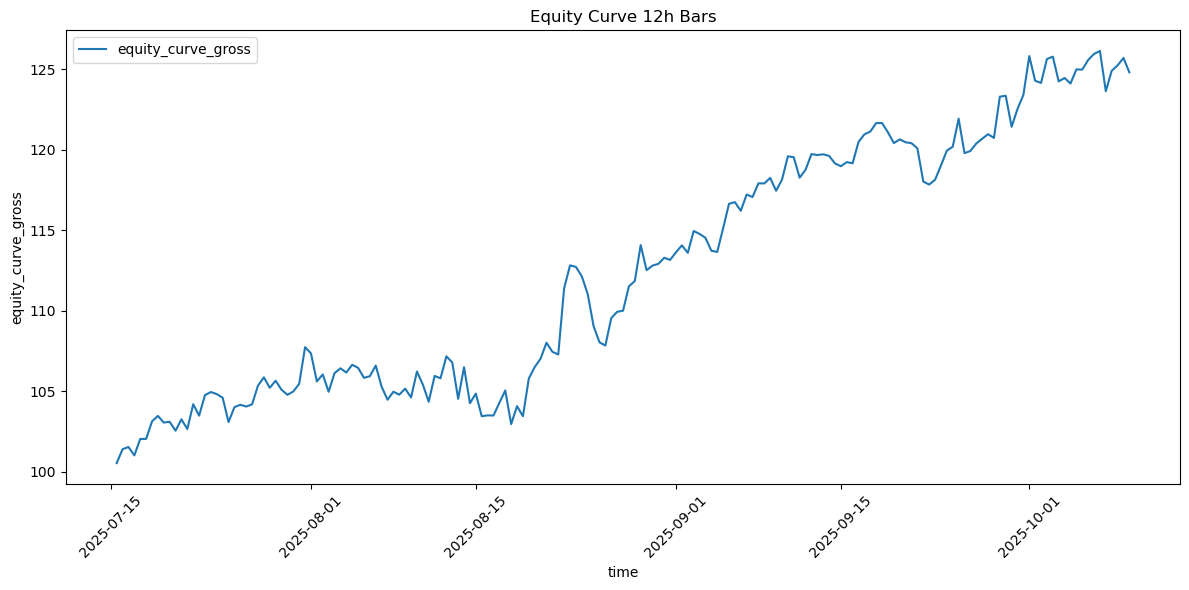

In [297]:
research.plot_static_timeseries(test_trades, 'Equity Curve', 'equity_curve_gross', time_interval)

### display the net equity curve for constant trade sizes

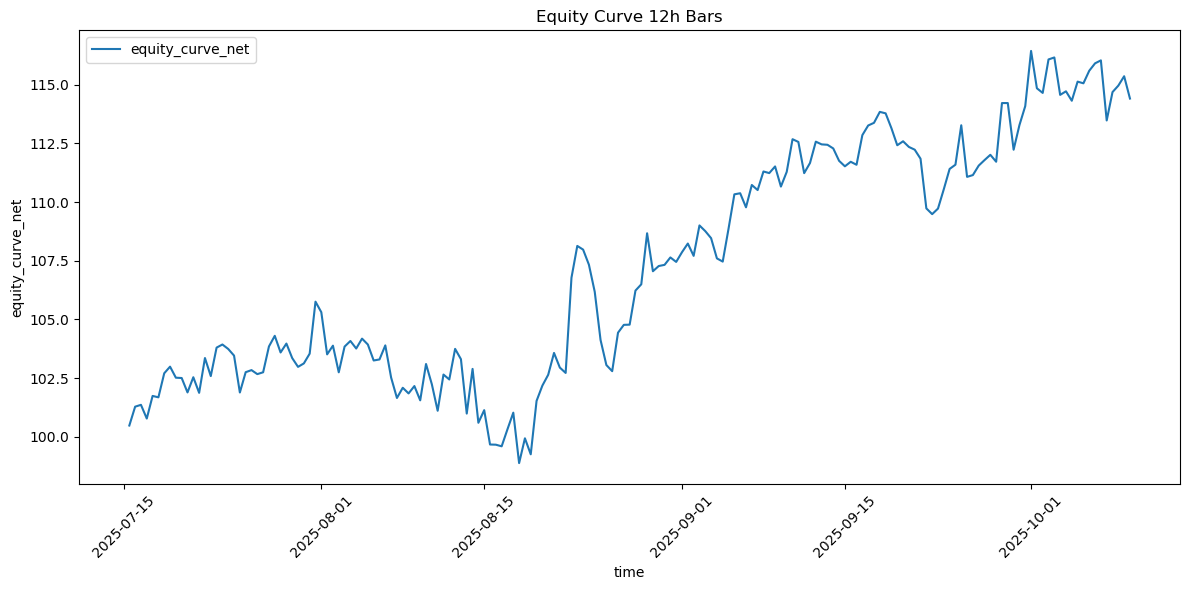

In [298]:
# performance trajectory of our trading strategy using a constant trade size over time.
research.plot_static_timeseries(test_trades, 'Equity Curve', 'equity_curve_net', time_interval)

### evaluate total gross return of using constant trade value

In [299]:
constant_trade_value_gross_return = test_trades['equity_curve_gross'][-1] / capital - 1
constant_trade_value_gross_return

0.24797798231639812

### evaluate total net return of using constant trade value

In [300]:
constant_trade_value_net_return = test_trades['equity_curve_net'][-1] / capital - 1
constant_trade_value_net_return

0.14410358892170327

## experiment with compounding trade sizes

In [301]:
# 2 => 102 (100 + 2)
# 1 => 103 (100 + 2 + 1)
# -1 => 102 (100 + 2 + 1 - 1)

### re-investing profit from previous trade (compounding)

### trade analysis for compounding trade sizes

In [ ]:
test_trades = test_trades.with_columns(
    ((pl.col('cum_trade_log_return').exp()) * capital).shift().fill_null(capital).alias('pre_trade_value'),
    ((pl.col('cum_trade_log_return').exp()) * capital).alias('post_trade_value'),
).with_columns(
    (pl.col('pre_trade_value') / pl.col('open')).alias('trade_qty'),
    (pl.col('post_trade_value')-pl.col('pre_trade_value')).alias('trade_gross_pnl'),
)
# test_trades.select('open','trade_log_return','cum_trade_log_return','equity_curve','trade_value','trade_qty')
test_trades.select('datetime','open','close','trade_log_return','pre_trade_value','post_trade_value','trade_gross_pnl')

shape: (173, 7)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ datetime      ‚îÜ open     ‚îÜ close    ‚îÜ trade_log_ret ‚îÜ pre_trade_va ‚îÜ post_trade_v ‚îÜ trade_gross_ ‚îÇ
‚îÇ ---           ‚îÜ ---      ‚îÜ ---      ‚îÜ urn           ‚îÜ lue          ‚îÜ alue         ‚îÜ pnl          ‚îÇ
‚îÇ datetime[Œºs]  ‚îÜ f64      ‚îÜ f64      ‚îÜ ---           ‚îÜ ---          ‚îÜ ---          ‚îÜ ---          ‚îÇ
‚îÇ               ‚îÜ          ‚îÜ          ‚îÜ f64           ‚îÜ f64          ‚îÜ f64          ‚îÜ f64          ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2025-07-15    ‚îÜ 117110.4 ‚îÜ 117738.5 ‚îÜ 0.005349      ‚îÜ 100.0        ‚îÜ 100.536332   ‚îÜ 0.536332     ‚îÇ
‚îÇ 12:00:00      ‚îÜ          ‚îÜ          ‚îÜ               ‚îÜ              ‚îÜ              ‚îÜ              ‚îÇ
‚îÇ 2025-07-16    ‚îÜ 117738.6 ‚îÜ 118755.1 ‚îÜ 0.008597      ‚îÜ 100.536332   ‚îÜ 101.404401   ‚îÜ 0.86807      ‚îÇ
‚îÇ 00:00:00      ‚îÜ          ‚îÜ          ‚îÜ               ‚îÜ              ‚îÜ              ‚îÜ              ‚îÇ
‚îÇ 2025-07-16    ‚îÜ 118755.1 ‚îÜ 118590.7 ‚îÜ 0.001385      ‚îÜ 101.404401   ‚îÜ 101.544976   ‚îÜ 0.140575     ‚îÇ
‚îÇ 12:00:00      ‚îÜ          ‚îÜ          ‚îÜ               ‚îÜ              ‚îÜ              ‚îÜ              ‚îÇ
‚îÇ 2025-07-17    ‚îÜ 118590.7 ‚îÜ 117968.9 ‚îÜ -0.005257     ‚îÜ 101.544976   ‚îÜ 101.012551   ‚îÜ -0.532425    ‚îÇ
‚îÇ 00:00:00      ‚îÜ          ‚îÜ          ‚îÜ               ‚îÜ              ‚îÜ              ‚îÜ              ‚îÇ
‚îÇ 2025-07-17    ‚îÜ 117968.8 ‚îÜ 119176.6 ‚îÜ 0.010185      ‚îÜ 101.012551   ‚îÜ 102.046662   ‚îÜ 1.03411      ‚îÇ
‚îÇ 12:00:00      ‚îÜ          ‚îÜ          ‚îÜ               ‚îÜ              ‚îÜ              ‚îÜ              ‚îÇ
‚îÇ ‚Ä¶             ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶             ‚îÜ ‚Ä¶            ‚îÜ ‚Ä¶            ‚îÜ ‚Ä¶            ‚îÇ
‚îÇ 2025-10-07    ‚îÜ 124397.1 ‚îÜ 121286.5 ‚îÜ -0.025324     ‚îÜ 128.761487   ‚îÜ 125.541653   ‚îÜ -3.219834    ‚îÇ
‚îÇ 12:00:00      ‚îÜ          ‚îÜ          ‚îÜ               ‚îÜ              ‚îÜ              ‚îÜ              ‚îÇ
‚îÇ 2025-10-08    ‚îÜ 121286.6 ‚îÜ 122825.7 ‚îÜ 0.012611      ‚îÜ 125.541653   ‚îÜ 127.134854   ‚îÜ 1.5932       ‚îÇ
‚îÇ 00:00:00      ‚îÜ          ‚îÜ          ‚îÜ               ‚îÜ              ‚îÜ              ‚îÜ              ‚îÇ
‚îÇ 2025-10-08    ‚îÜ 122825.8 ‚îÜ 123237.5 ‚îÜ 0.003347      ‚îÜ 127.134854   ‚îÜ 127.561101   ‚îÜ 0.426247     ‚îÇ
‚îÇ 12:00:00      ‚îÜ          ‚îÜ          ‚îÜ               ‚îÜ              ‚îÜ              ‚îÜ              ‚îÇ
‚îÇ 2025-10-09    ‚îÜ 123237.4 ‚îÜ 122672.9 ‚îÜ 0.004592      ‚îÜ 127.561101   ‚îÜ 128.148199   ‚îÜ 0.587098     ‚îÇ
‚îÇ 00:00:00      ‚îÜ          ‚îÜ          ‚îÜ               ‚îÜ              ‚îÜ              ‚îÜ              ‚îÇ
‚îÇ 2025-10-09    ‚îÜ 122673.0 ‚îÜ 121579.3 ‚îÜ -0.008955     ‚îÜ 128.148199   ‚îÜ 127.005788   ‚îÜ -1.142411    ‚îÇ
‚îÇ 12:00:00      ‚îÜ          ‚îÜ          ‚îÜ               ‚îÜ              ‚îÜ              ‚îÜ              ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

### add transaction fees

In [316]:
test_trades = test_trades.with_columns(
    (pl.col('pre_trade_value') * binance.TAKER_FEE + pl.col('post_trade_value') * binance.TAKER_FEE).alias('tx_fees'),
)
test_trades.select('datetime','open','close','trade_log_return','pre_trade_value','post_trade_value','trade_gross_pnl', 'tx_fees')

shape: (173, 8)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ datetime    ‚îÜ open     ‚îÜ close    ‚îÜ trade_log_ ‚îÜ pre_trade_ ‚îÜ post_trade ‚îÜ trade_gros ‚îÜ tx_fees  ‚îÇ
‚îÇ ---         ‚îÜ ---      ‚îÜ ---      ‚îÜ return     ‚îÜ value      ‚îÜ _value     ‚îÜ s_pnl      ‚îÜ ---      ‚îÇ
‚îÇ datetime[Œºs ‚îÜ f64      ‚îÜ f64      ‚îÜ ---        ‚îÜ ---        ‚îÜ ---        ‚îÜ ---        ‚îÜ f64      ‚îÇ
‚îÇ ]           ‚îÜ          ‚îÜ          ‚îÜ f64        ‚îÜ f64        ‚îÜ f64        ‚îÜ f64        ‚îÜ          ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2025-07-15  ‚îÜ 117110.4 ‚îÜ 117738.5 ‚îÜ 0.005349   ‚îÜ 100.0      ‚îÜ 100.536332 ‚îÜ 0.536332   ‚îÜ 0.060161 ‚îÇ
‚îÇ 12:00:00    ‚îÜ          ‚îÜ          ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ          ‚îÇ
‚îÇ 2025-07-16  ‚îÜ 117738.6 ‚îÜ 118755.1 ‚îÜ 0.008597   ‚îÜ 100.536332 ‚îÜ 101.404401 ‚îÜ 0.86807    ‚îÜ 0.060582 ‚îÇ
‚îÇ 00:00:00    ‚îÜ          ‚îÜ          ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ          ‚îÇ
‚îÇ 2025-07-16  ‚îÜ 118755.1 ‚îÜ 118590.7 ‚îÜ 0.001385   ‚îÜ 101.404401 ‚îÜ 101.544976 ‚îÜ 0.140575   ‚îÜ 0.060885 ‚îÇ
‚îÇ 12:00:00    ‚îÜ          ‚îÜ          ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ          ‚îÇ
‚îÇ 2025-07-17  ‚îÜ 118590.7 ‚îÜ 117968.9 ‚îÜ -0.005257  ‚îÜ 101.544976 ‚îÜ 101.012551 ‚îÜ -0.532425  ‚îÜ 0.060767 ‚îÇ
‚îÇ 00:00:00    ‚îÜ          ‚îÜ          ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ          ‚îÇ
‚îÇ 2025-07-17  ‚îÜ 117968.8 ‚îÜ 119176.6 ‚îÜ 0.010185   ‚îÜ 101.012551 ‚îÜ 102.046662 ‚îÜ 1.03411    ‚îÜ 0.060918 ‚îÇ
‚îÇ 12:00:00    ‚îÜ          ‚îÜ          ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ          ‚îÇ
‚îÇ ‚Ä¶           ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶        ‚îÇ
‚îÇ 2025-10-07  ‚îÜ 124397.1 ‚îÜ 121286.5 ‚îÜ -0.025324  ‚îÜ 128.761487 ‚îÜ 125.541653 ‚îÜ -3.219834  ‚îÜ 0.076291 ‚îÇ
‚îÇ 12:00:00    ‚îÜ          ‚îÜ          ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ          ‚îÇ
‚îÇ 2025-10-08  ‚îÜ 121286.6 ‚îÜ 122825.7 ‚îÜ 0.012611   ‚îÜ 125.541653 ‚îÜ 127.134854 ‚îÜ 1.5932     ‚îÜ 0.075803 ‚îÇ
‚îÇ 00:00:00    ‚îÜ          ‚îÜ          ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ          ‚îÇ
‚îÇ 2025-10-08  ‚îÜ 122825.8 ‚îÜ 123237.5 ‚îÜ 0.003347   ‚îÜ 127.134854 ‚îÜ 127.561101 ‚îÜ 0.426247   ‚îÜ 0.076409 ‚îÇ
‚îÇ 12:00:00    ‚îÜ          ‚îÜ          ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ          ‚îÇ
‚îÇ 2025-10-09  ‚îÜ 123237.4 ‚îÜ 122672.9 ‚îÜ 0.004592   ‚îÜ 127.561101 ‚îÜ 128.148199 ‚îÜ 0.587098   ‚îÜ 0.076713 ‚îÇ
‚îÇ 00:00:00    ‚îÜ          ‚îÜ          ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ          ‚îÇ
‚îÇ 2025-10-09  ‚îÜ 122673.0 ‚îÜ 121579.3 ‚îÜ -0.008955  ‚îÜ 128.148199 ‚îÜ 127.005788 ‚îÜ -1.142411  ‚îÜ 0.076546 ‚îÇ
‚îÇ 12:00:00    ‚îÜ          ‚îÜ          ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ          ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

### add net returns for compounding trade sizes

In [318]:
test_trades = test_trades.with_columns(
    (pl.col('trade_gross_pnl') - pl.col('tx_fees')).alias('trade_net_pnl')
)

### explain compounding (time additivity)

In [303]:
pnl1 = capital * np.exp(0.005349)
pnl1

np.float64(100.5363331442067)

In [304]:
pnl2 = pnl1 * np.exp(0.008597)
pnl2

np.float64(101.40436991002386)

In [305]:
pnl3 = pnl2 * np.exp(0.001385)
pnl3

np.float64(101.5449122654644)

In [306]:
((capital * np.exp(0.005349)) * np.exp(0.008597)) * np.exp(0.001385)

np.float64(101.5449122654644)

In [307]:
capital * np.exp(0.005349 + 0.008597 + 0.001385)

np.float64(101.5449122654644)

In [308]:
# Hopefully you can see that log returns aren‚Äôt just some academic thing ‚Äî they‚Äôre actually really practical once you start using them.

### calculate gross total return for compounding trade sizes

In [317]:
compound_gross_return = np.exp(test_trades['cum_trade_log_return'][-1]) - 1
compound_gross_return

np.float64(0.27005787784880453)

In [310]:
np.round(compound_gross_return - constant_trade_value_gross_return, 2)

np.float64(0.02)

In [311]:
test_trades

shape: (173, 22)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ datetime   ‚îÜ open     ‚îÜ high     ‚îÜ low      ‚îÜ ‚Ä¶ ‚îÜ tx_fees  ‚îÜ trade_net_ ‚îÜ equity_cur ‚îÜ equity_cu ‚îÇ
‚îÇ ---        ‚îÜ ---      ‚îÜ ---      ‚îÜ ---      ‚îÜ   ‚îÜ ---      ‚îÜ pnl        ‚îÜ ve_net     ‚îÜ rve_gross ‚îÇ
‚îÇ datetime[Œº ‚îÜ f64      ‚îÜ f64      ‚îÜ f64      ‚îÜ   ‚îÜ f64      ‚îÜ ---        ‚îÜ ---        ‚îÜ ---       ‚îÇ
‚îÇ s]         ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ          ‚îÜ f64        ‚îÜ f64        ‚îÜ f64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2025-07-15 ‚îÜ 117110.4 ‚îÜ 118499.8 ‚îÜ 115678.1 ‚îÜ ‚Ä¶ ‚îÜ 0.060161 ‚îÜ 0.476171   ‚îÜ 100.476171 ‚îÜ 100.53633 ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ          ‚îÜ            ‚îÜ            ‚îÜ 2         ‚îÇ
‚îÇ 2025-07-16 ‚îÜ 117738.6 ‚îÜ 119299.9 ‚îÜ 117017.1 ‚îÜ ‚Ä¶ ‚îÜ 0.060259 ‚îÜ 0.80318    ‚îÜ 101.27935  ‚îÜ 101.39977 ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ          ‚îÜ            ‚îÜ            ‚îÜ           ‚îÇ
‚îÇ 2025-07-16 ‚îÜ 118755.1 ‚îÜ 120100.0 ‚îÜ 118156.0 ‚îÜ ‚Ä¶ ‚îÜ 0.060042 ‚îÜ 0.078586   ‚îÜ 101.357937 ‚îÜ 101.53839 ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ          ‚îÜ            ‚îÜ            ‚îÜ 8         ‚îÇ
‚îÇ 2025-07-17 ‚îÜ 118590.7 ‚îÜ 119216.4 ‚îÜ 117663.6 ‚îÜ ‚Ä¶ ‚îÜ 0.059843 ‚îÜ -0.584167  ‚îÜ 100.77377  ‚îÜ 101.01407 ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ          ‚îÜ            ‚îÜ            ‚îÜ 4         ‚îÇ
‚îÇ 2025-07-17 ‚îÜ 117968.8 ‚îÜ 120951.5 ‚îÜ 117412.8 ‚îÜ ‚Ä¶ ‚îÜ 0.060307 ‚îÜ 0.963437   ‚îÜ 101.737207 ‚îÜ 102.03781 ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ          ‚îÜ            ‚îÜ            ‚îÜ 8         ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶ ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶         ‚îÇ
‚îÇ 2025-10-07 ‚îÜ 124397.1 ‚îÜ 125098.0 ‚îÜ 120516.0 ‚îÜ ‚Ä¶ ‚îÜ 0.05925  ‚îÜ -2.559869  ‚îÜ 113.477606 ‚îÜ 123.62469 ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ          ‚îÜ            ‚îÜ            ‚îÜ 3         ‚îÇ
‚îÇ 2025-10-08 ‚îÜ 121286.6 ‚îÜ 123150.0 ‚îÜ 121005.3 ‚îÜ ‚Ä¶ ‚îÜ 0.060381 ‚îÜ 1.208681   ‚îÜ 114.686286 ‚îÜ 124.89375 ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ          ‚îÜ            ‚îÜ            ‚îÜ 4         ‚îÇ
‚îÇ 2025-10-08 ‚îÜ 122825.8 ‚îÜ 124170.6 ‚îÜ 121607.8 ‚îÜ ‚Ä¶ ‚îÜ 0.060101 ‚îÜ 0.275171   ‚îÜ 114.961458 ‚îÜ 125.22902 ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ          ‚îÜ            ‚îÜ            ‚îÜ 6         ‚îÇ
‚îÇ 2025-10-09 ‚îÜ 123237.4 ‚îÜ 123279.7 ‚îÜ 121081.5 ‚îÜ ‚Ä¶ ‚îÜ 0.060138 ‚îÜ 0.40011    ‚îÜ 115.361568 ‚îÜ 125.68927 ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ          ‚îÜ            ‚îÜ            ‚îÜ 5         ‚îÇ
‚îÇ 2025-10-09 ‚îÜ 122673.0 ‚îÜ 123740.1 ‚îÜ 119572.8 ‚îÜ ‚Ä¶ ‚îÜ 0.059733 ‚îÜ -0.951209  ‚îÜ 114.410359 ‚îÜ 124.79779 ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ          ‚îÜ            ‚îÜ            ‚îÜ 8         ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

### display compounding trade equity curve

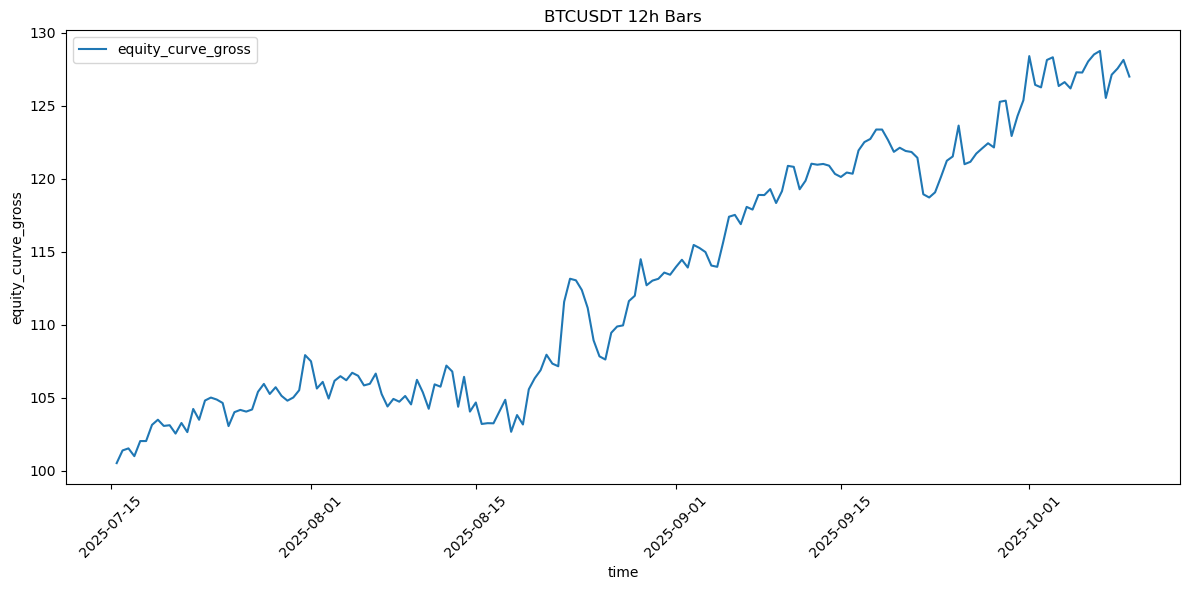

In [315]:
test_trades = test_trades.with_columns((capital+pl.col('trade_gross_pnl').cum_sum()).alias('equity_curve_gross'))
research.plot_static_timeseries(test_trades, sym, 'equity_curve_gross', time_interval)

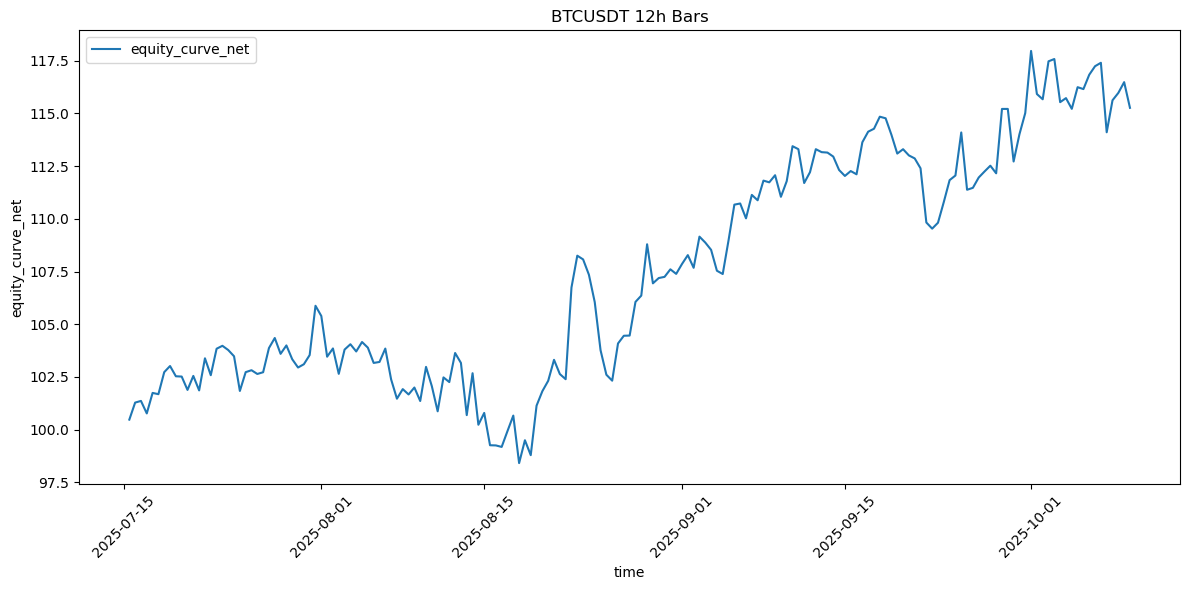

In [319]:
test_trades = test_trades.with_columns((capital+pl.col('trade_net_pnl').cum_sum()).alias('equity_curve_net'))
research.plot_static_timeseries(test_trades, sym, 'equity_curve_net', time_interval)

## Leverage

In [ ]:
# what if i told you that we could multiply our pnl by leveraging (which is essentially borrowing money)

In [ ]:
# just remember, it amplifies BOTH your profit and losses so it's important to have a postive expected value, and also low standard deviation of returns (minimising risj)

In [ ]:
# the idea of chosing a model with a high sharpe is that it reduces risk, reduces the drawdowns, so we can use leverage

In [ ]:
# key decision 3: should we use leverage? if so, how much?

In [320]:
capital

100

In [344]:
leverage = 4

In [345]:
capital * leverage

400

In [346]:
test_trades = test_trades.with_columns(
    (pl.col('trade_log_return') *  leverage).alias('trade_lev_log_return')
).with_columns(
    (pl.col('trade_lev_log_return').cum_sum().alias('cum_trade_lev_log_return'))
)
test_trades.select('datetime','trade_log_return','trade_lev_log_return','cum_trade_lev_log_return')

shape: (173, 4)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ datetime            ‚îÜ trade_log_return ‚îÜ trade_lev_log_return ‚îÜ cum_trade_lev_log_return ‚îÇ
‚îÇ ---                 ‚îÜ ---              ‚îÜ ---                  ‚îÜ ---                      ‚îÇ
‚îÇ datetime[Œºs]        ‚îÜ f64              ‚îÜ f64                  ‚îÜ f64                      ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2025-07-15 12:00:00 ‚îÜ 0.005349         ‚îÜ 0.021396             ‚îÜ 0.021396                 ‚îÇ
‚îÇ 2025-07-16 00:00:00 ‚îÜ 0.008597         ‚îÜ 0.034389             ‚îÜ 0.055785                 ‚îÇ
‚îÇ 2025-07-16 12:00:00 ‚îÜ 0.001385         ‚îÜ 0.005541             ‚îÜ 0.061327                 ‚îÇ
‚îÇ 2025-07-17 00:00:00 ‚îÜ -0.005257        ‚îÜ -0.021028            ‚îÜ 0.040298                 ‚îÇ
‚îÇ 2025-07-17 12:00:00 ‚îÜ 0.010185         ‚îÜ 0.040742             ‚îÜ 0.08104                  ‚îÇ
‚îÇ ‚Ä¶                   ‚îÜ ‚Ä¶                ‚îÜ ‚Ä¶                    ‚îÜ ‚Ä¶                        ‚îÇ
‚îÇ 2025-10-07 12:00:00 ‚îÜ -0.025324        ‚îÜ -0.101297            ‚îÜ 0.90987                  ‚îÇ
‚îÇ 2025-10-08 00:00:00 ‚îÜ 0.012611         ‚îÜ 0.050443             ‚îÜ 0.960313                 ‚îÇ
‚îÇ 2025-10-08 12:00:00 ‚îÜ 0.003347         ‚îÜ 0.013388             ‚îÜ 0.973701                 ‚îÇ
‚îÇ 2025-10-09 00:00:00 ‚îÜ 0.004592         ‚îÜ 0.018368             ‚îÜ 0.992069                 ‚îÇ
‚îÇ 2025-10-09 12:00:00 ‚îÜ -0.008955        ‚îÜ -0.035819            ‚îÜ 0.95625                  ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

### add trade leveraged pnl

In [355]:
lev_capital = leverage * capital
test_trades = test_trades.with_columns(
    ((pl.col('cum_trade_lev_log_return').exp()) * lev_capital).shift().fill_null(lev_capital).alias('pre_trade_value'),
    ((pl.col('cum_trade_lev_log_return').exp()) * lev_capital).alias('post_trade_value'),
).with_columns(
    (pl.col('pre_trade_value') / pl.col('open')).alias('trade_qty'),
    (pl.col('post_trade_value')-pl.col('pre_trade_value')).alias('trade_gross_pnl'),
)
test_trades.select('datetime','open','close','pre_trade_value','post_trade_value','trade_gross_pnl','cum_trade_lev_log_return')

shape: (173, 7)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ datetime      ‚îÜ open     ‚îÜ close    ‚îÜ pre_trade_val ‚îÜ post_trade_v ‚îÜ trade_gross_ ‚îÜ cum_trade_le ‚îÇ
‚îÇ ---           ‚îÜ ---      ‚îÜ ---      ‚îÜ ue            ‚îÜ alue         ‚îÜ pnl          ‚îÜ v_log_return ‚îÇ
‚îÇ datetime[Œºs]  ‚îÜ f64      ‚îÜ f64      ‚îÜ ---           ‚îÜ ---          ‚îÜ ---          ‚îÜ ---          ‚îÇ
‚îÇ               ‚îÜ          ‚îÜ          ‚îÜ f64           ‚îÜ f64          ‚îÜ f64          ‚îÜ f64          ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2025-07-15    ‚îÜ 117110.4 ‚îÜ 117738.5 ‚îÜ 400.0         ‚îÜ 408.650588   ‚îÜ 8.650588     ‚îÜ 0.021396     ‚îÇ
‚îÇ 12:00:00      ‚îÜ          ‚îÜ          ‚îÜ               ‚îÜ              ‚îÜ              ‚îÜ              ‚îÇ
‚îÇ 2025-07-16    ‚îÜ 117738.6 ‚îÜ 118755.1 ‚îÜ 408.650588    ‚îÜ 422.948231   ‚îÜ 14.297643    ‚îÜ 0.055785     ‚îÇ
‚îÇ 00:00:00      ‚îÜ          ‚îÜ          ‚îÜ               ‚îÜ              ‚îÜ              ‚îÜ              ‚îÇ
‚îÇ 2025-07-16    ‚îÜ 118755.1 ‚îÜ 118590.7 ‚îÜ 422.948231    ‚îÜ 425.298412   ‚îÜ 2.350181     ‚îÜ 0.061327     ‚îÇ
‚îÇ 12:00:00      ‚îÜ          ‚îÜ          ‚îÜ               ‚îÜ              ‚îÜ              ‚îÜ              ‚îÇ
‚îÇ 2025-07-17    ‚îÜ 118590.7 ‚îÜ 117968.9 ‚îÜ 425.298412    ‚îÜ 416.448546   ‚îÜ -8.849866    ‚îÜ 0.040298     ‚îÇ
‚îÇ 00:00:00      ‚îÜ          ‚îÜ          ‚îÜ               ‚îÜ              ‚îÜ              ‚îÜ              ‚îÇ
‚îÇ 2025-07-17    ‚îÜ 117968.8 ‚îÜ 119176.6 ‚îÜ 416.448546    ‚îÜ 433.765689   ‚îÜ 17.317142    ‚îÜ 0.08104      ‚îÇ
‚îÇ 12:00:00      ‚îÜ          ‚îÜ          ‚îÜ               ‚îÜ              ‚îÜ              ‚îÜ              ‚îÇ
‚îÇ ‚Ä¶             ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶             ‚îÜ ‚Ä¶            ‚îÜ ‚Ä¶            ‚îÜ ‚Ä¶            ‚îÇ
‚îÇ 2025-10-07    ‚îÜ 124397.1 ‚îÜ 121286.5 ‚îÜ 1099.522013   ‚îÜ 993.599496   ‚îÜ -105.922516  ‚îÜ 0.90987      ‚îÇ
‚îÇ 12:00:00      ‚îÜ          ‚îÜ          ‚îÜ               ‚îÜ              ‚îÜ              ‚îÜ              ‚îÇ
‚îÇ 2025-10-08    ‚îÜ 121286.6 ‚îÜ 122825.7 ‚îÜ 993.599496    ‚îÜ 1045.005316  ‚îÜ 51.405819    ‚îÜ 0.960313     ‚îÇ
‚îÇ 00:00:00      ‚îÜ          ‚îÜ          ‚îÜ               ‚îÜ              ‚îÜ              ‚îÜ              ‚îÇ
‚îÇ 2025-10-08    ‚îÜ 122825.8 ‚îÜ 123237.5 ‚îÜ 1045.005316   ‚îÜ 1059.090388  ‚îÜ 14.085072    ‚îÜ 0.973701     ‚îÇ
‚îÇ 12:00:00      ‚îÜ          ‚îÜ          ‚îÜ               ‚îÜ              ‚îÜ              ‚îÜ              ‚îÇ
‚îÇ 2025-10-09    ‚îÜ 123237.4 ‚îÜ 122672.9 ‚îÜ 1059.090388   ‚îÜ 1078.723193  ‚îÜ 19.632805    ‚îÜ 0.992069     ‚îÇ
‚îÇ 00:00:00      ‚îÜ          ‚îÜ          ‚îÜ               ‚îÜ              ‚îÜ              ‚îÜ              ‚îÇ
‚îÇ 2025-10-09    ‚îÜ 122673.0 ‚îÜ 121579.3 ‚îÜ 1078.723193   ‚îÜ 1040.768267  ‚îÜ -37.954926   ‚îÜ 0.95625      ‚îÇ
‚îÇ 12:00:00      ‚îÜ          ‚îÜ          ‚îÜ               ‚îÜ              ‚îÜ              ‚îÜ              ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

### add transactions fees

In [363]:
test_trades = test_trades.with_columns(
    ((pl.col('pre_trade_value') * binance.TAKER_FEE) + (pl.col('post_trade_value') * binance.TAKER_FEE)).alias('tx_fees'),
).with_columns(
    (pl.col('trade_gross_pnl')-pl.col('tx_fees')).alias('trade_net_pnl')
)
test_trades.select('datetime','open','close','pre_trade_value','post_trade_value','trade_gross_pnl','tx_fees', 'trade_net_pnl','cum_trade_lev_log_return')

shape: (173, 9)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ datetime   ‚îÜ open     ‚îÜ close    ‚îÜ pre_trade_ ‚îÜ ‚Ä¶ ‚îÜ trade_gro ‚îÜ tx_fees  ‚îÜ trade_net ‚îÜ cum_trade ‚îÇ
‚îÇ ---        ‚îÜ ---      ‚îÜ ---      ‚îÜ value      ‚îÜ   ‚îÜ ss_pnl    ‚îÜ ---      ‚îÜ _pnl      ‚îÜ _lev_log_ ‚îÇ
‚îÇ datetime[Œº ‚îÜ f64      ‚îÜ f64      ‚îÜ ---        ‚îÜ   ‚îÜ ---       ‚îÜ f64      ‚îÜ ---       ‚îÜ return    ‚îÇ
‚îÇ s]         ‚îÜ          ‚îÜ          ‚îÜ f64        ‚îÜ   ‚îÜ f64       ‚îÜ          ‚îÜ f64       ‚îÜ ---       ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ          ‚îÜ            ‚îÜ   ‚îÜ           ‚îÜ          ‚îÜ           ‚îÜ f64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2025-07-15 ‚îÜ 117110.4 ‚îÜ 117738.5 ‚îÜ 400.0      ‚îÜ ‚Ä¶ ‚îÜ 8.650588  ‚îÜ 0.242595 ‚îÜ 8.407993  ‚îÜ 0.021396  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ            ‚îÜ   ‚îÜ           ‚îÜ          ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-16 ‚îÜ 117738.6 ‚îÜ 118755.1 ‚îÜ 408.650588 ‚îÜ ‚Ä¶ ‚îÜ 14.297643 ‚îÜ 0.24948  ‚îÜ 14.048163 ‚îÜ 0.055785  ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ            ‚îÜ   ‚îÜ           ‚îÜ          ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-16 ‚îÜ 118755.1 ‚îÜ 118590.7 ‚îÜ 422.948231 ‚îÜ ‚Ä¶ ‚îÜ 2.350181  ‚îÜ 0.254474 ‚îÜ 2.095707  ‚îÜ 0.061327  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ            ‚îÜ   ‚îÜ           ‚îÜ          ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-17 ‚îÜ 118590.7 ‚îÜ 117968.9 ‚îÜ 425.298412 ‚îÜ ‚Ä¶ ‚îÜ -8.849866 ‚îÜ 0.252524 ‚îÜ -9.10239  ‚îÜ 0.040298  ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ            ‚îÜ   ‚îÜ           ‚îÜ          ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-17 ‚îÜ 117968.8 ‚îÜ 119176.6 ‚îÜ 416.448546 ‚îÜ ‚Ä¶ ‚îÜ 17.317142 ‚îÜ 0.255064 ‚îÜ 17.062078 ‚îÜ 0.08104   ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ            ‚îÜ   ‚îÜ           ‚îÜ          ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶ ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÇ
‚îÇ 2025-10-07 ‚îÜ 124397.1 ‚îÜ 121286.5 ‚îÜ 1099.52201 ‚îÜ ‚Ä¶ ‚îÜ -105.9225 ‚îÜ 0.627936 ‚îÜ -106.5504 ‚îÜ 0.90987   ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ 3          ‚îÜ   ‚îÜ 16        ‚îÜ          ‚îÜ 53        ‚îÜ           ‚îÇ
‚îÇ 2025-10-08 ‚îÜ 121286.6 ‚îÜ 122825.7 ‚îÜ 993.599496 ‚îÜ ‚Ä¶ ‚îÜ 51.405819 ‚îÜ 0.611581 ‚îÜ 50.794238 ‚îÜ 0.960313  ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ            ‚îÜ   ‚îÜ           ‚îÜ          ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-08 ‚îÜ 122825.8 ‚îÜ 123237.5 ‚îÜ 1045.00531 ‚îÜ ‚Ä¶ ‚îÜ 14.085072 ‚îÜ 0.631229 ‚îÜ 13.453843 ‚îÜ 0.973701  ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ 6          ‚îÜ   ‚îÜ           ‚îÜ          ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-09 ‚îÜ 123237.4 ‚îÜ 122672.9 ‚îÜ 1059.09038 ‚îÜ ‚Ä¶ ‚îÜ 19.632805 ‚îÜ 0.641344 ‚îÜ 18.991461 ‚îÜ 0.992069  ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ 8          ‚îÜ   ‚îÜ           ‚îÜ          ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-09 ‚îÜ 122673.0 ‚îÜ 121579.3 ‚îÜ 1078.72319 ‚îÜ ‚Ä¶ ‚îÜ -37.95492 ‚îÜ 0.635847 ‚îÜ -38.59077 ‚îÜ 0.95625   ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ 3          ‚îÜ   ‚îÜ 6         ‚îÜ          ‚îÜ 4         ‚îÜ           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥

In [368]:
test_trades = test_trades.with_columns(
    (pl.col('trade_net_pnl').cum_sum()).alias('cum_trade_net_pnl'),
    (capital+(pl.col('trade_net_pnl').cum_sum())).alias('equity_curve_net'),
)
test_trades.select('datetime','open','close','pre_trade_value','post_trade_value','trade_gross_pnl','cum_trade_lev_log_return', 'trade_net_pnl','cum_trade_net_pnl','equity_curve_net')

shape: (173, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ datetime   ‚îÜ open     ‚îÜ close    ‚îÜ pre_trade ‚îÜ ‚Ä¶ ‚îÜ cum_trade ‚îÜ trade_net ‚îÜ cum_trade ‚îÜ equity_cu ‚îÇ
‚îÇ ---        ‚îÜ ---      ‚îÜ ---      ‚îÜ _value    ‚îÜ   ‚îÜ _lev_log_ ‚îÜ _pnl      ‚îÜ _net_pnl  ‚îÜ rve_net   ‚îÇ
‚îÇ datetime[Œº ‚îÜ f64      ‚îÜ f64      ‚îÜ ---       ‚îÜ   ‚îÜ return    ‚îÜ ---       ‚îÜ ---       ‚îÜ ---       ‚îÇ
‚îÇ s]         ‚îÜ          ‚îÜ          ‚îÜ f64       ‚îÜ   ‚îÜ ---       ‚îÜ f64       ‚îÜ f64       ‚îÜ f64       ‚îÇ
‚îÇ            ‚îÜ          ‚îÜ          ‚îÜ           ‚îÜ   ‚îÜ f64       ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2025-07-15 ‚îÜ 117110.4 ‚îÜ 117738.5 ‚îÜ 400.0     ‚îÜ ‚Ä¶ ‚îÜ 0.021396  ‚îÜ 8.407993  ‚îÜ 8.407993  ‚îÜ 108.40799 ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 3         ‚îÇ
‚îÇ 2025-07-16 ‚îÜ 117738.6 ‚îÜ 118755.1 ‚îÜ 408.65058 ‚îÜ ‚Ä¶ ‚îÜ 0.055785  ‚îÜ 14.048163 ‚îÜ 22.456156 ‚îÜ 122.45615 ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ 8         ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 6         ‚îÇ
‚îÇ 2025-07-16 ‚îÜ 118755.1 ‚îÜ 118590.7 ‚îÜ 422.94823 ‚îÜ ‚Ä¶ ‚îÜ 0.061327  ‚îÜ 2.095707  ‚îÜ 24.551863 ‚îÜ 124.55186 ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ 1         ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 3         ‚îÇ
‚îÇ 2025-07-17 ‚îÜ 118590.7 ‚îÜ 117968.9 ‚îÜ 425.29841 ‚îÜ ‚Ä¶ ‚îÜ 0.040298  ‚îÜ -9.10239  ‚îÜ 15.449473 ‚îÜ 115.44947 ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ 2         ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 3         ‚îÇ
‚îÇ 2025-07-17 ‚îÜ 117968.8 ‚îÜ 119176.6 ‚îÜ 416.44854 ‚îÜ ‚Ä¶ ‚îÜ 0.08104   ‚îÜ 17.062078 ‚îÜ 32.511552 ‚îÜ 132.51155 ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ 6         ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ 2         ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶ ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÇ
‚îÇ 2025-10-07 ‚îÜ 124397.1 ‚îÜ 121286.5 ‚îÜ 1099.5220 ‚îÜ ‚Ä¶ ‚îÜ 0.90987   ‚îÜ -106.5504 ‚îÜ 525.85178 ‚îÜ 625.85178 ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ 13        ‚îÜ   ‚îÜ           ‚îÜ 53        ‚îÜ 2         ‚îÜ 2         ‚îÇ
‚îÇ 2025-10-08 ‚îÜ 121286.6 ‚îÜ 122825.7 ‚îÜ 993.59949 ‚îÜ ‚Ä¶ ‚îÜ 0.960313  ‚îÜ 50.794238 ‚îÜ 576.64602 ‚îÜ 676.64602 ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ 6         ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-08 ‚îÜ 122825.8 ‚îÜ 123237.5 ‚îÜ 1045.0053 ‚îÜ ‚Ä¶ ‚îÜ 0.973701  ‚îÜ 13.453843 ‚îÜ 590.09986 ‚îÜ 690.09986 ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ 16        ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ 4         ‚îÜ 4         ‚îÇ
‚îÇ 2025-10-09 ‚îÜ 123237.4 ‚îÜ 122672.9 ‚îÜ 1059.0903 ‚îÜ ‚Ä¶ ‚îÜ 0.992069  ‚îÜ 18.991461 ‚îÜ 609.09132 ‚îÜ 709.09132 ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ 88        ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ 4         ‚îÜ 4         ‚îÇ
‚îÇ 2025-10-09 ‚îÜ 122673.0 ‚îÜ 121579.3 ‚îÜ 1078.7231 ‚îÜ ‚Ä¶ ‚îÜ 0.95625   ‚îÜ -38.59077 ‚îÜ 570.50055 ‚îÜ 670.50055 ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ 93        ‚îÜ   ‚îÜ           ‚îÜ 4         ‚îÜ 1         ‚îÜ 1         ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚î

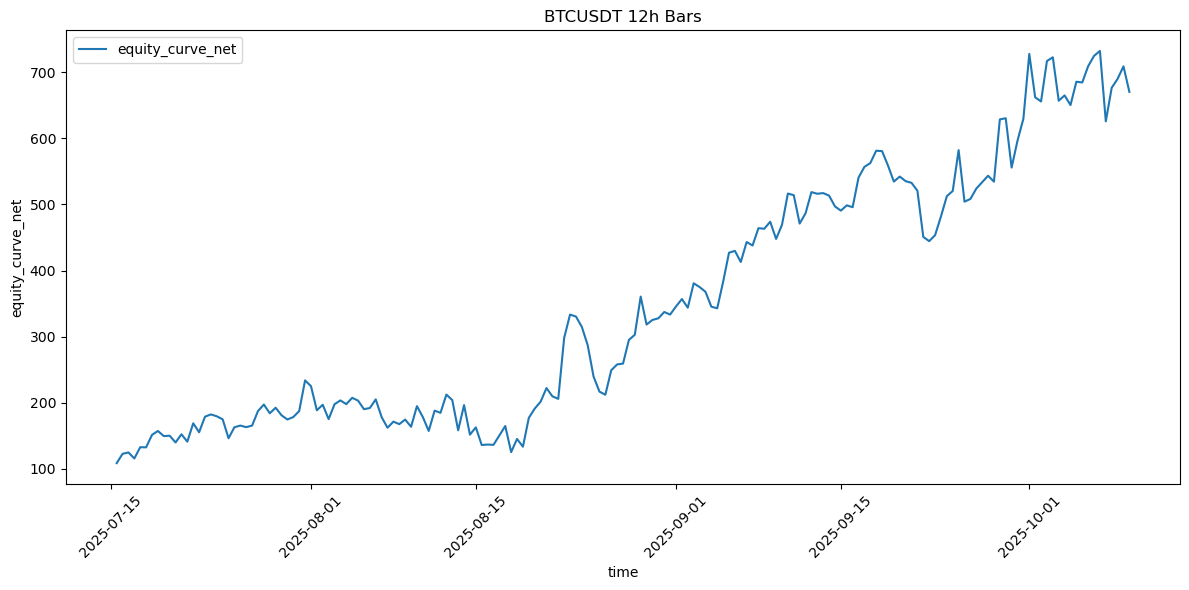

In [369]:
research.plot_static_timeseries(test_trades, sym, 'equity_curve_net', time_interval)

### total leveraged return

In [371]:
test_trades['cum_trade_net_pnl'][-1]/capital

5.705005508020471

In [ ]:
# reason for this huge pnl is the combination of compounding and leverage

### factor liquidation (price moves against us too much)

In [372]:
# leverage is a double edged sword. you can amplify profits, but too much leverage and you can wipe out all your money

In [ ]:
# Equity = Maintenance Margin
# calulcation differs from different exchanges


In [370]:
maintenance_margin = 0.005

def long_liquidation_price(p, l, mmr):
    return (p * l) / (l + 1 - mmr * l)

def short_liquidation_price(p, l, mmr):
    return (p * l) / (l - 1 + mmr * l)

### show how leverage affects long positions

In [377]:
long_liquidation_price(20000, 2, maintenance_margin)

13377.926421404682

In [374]:
long_liquidation_price(20000, 4, maintenance_margin)

16064.257028112448

In [375]:
long_liquidation_price(20000, 10, maintenance_margin)

18264.840182648404

In [376]:
long_liquidation_price(20000, 50, maintenance_margin)

19704.433497536946

### show how leverage affects short positions

In [379]:
short_liquidation_price(20000, 2, maintenance_margin)

39603.960396039605

In [380]:
short_liquidation_price(20000, 4, maintenance_margin)

26490.066225165563

In [381]:
short_liquidation_price(20000, 10, maintenance_margin)

22099.447513812152

In [382]:
short_liquidation_price(20000, 60, maintenance_margin)

20236.087689713324

### add liquidation prices to our trades

In [393]:
leverage = 50
test_trades = test_trades.with_columns(
    pl.when(pl.col("dir_signal") == 1)  # long position
      .then(
          (pl.col("open") * leverage)
          / (leverage + 1 - maintenance_margin * leverage)
      )
      .when(pl.col("dir_signal") == -1)  # short position
      .then(
          (pl.col("open") * leverage)
          / (leverage - 1 + maintenance_margin * leverage)
      )
      .otherwise(None)
      .alias("liquidation_price")
)
test_trades.select('datetime','open','high','low','close','liquidation_price','dir_signal')

shape: (173, 7)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ datetime            ‚îÜ open     ‚îÜ high     ‚îÜ low      ‚îÜ close    ‚îÜ liquidation_price ‚îÜ dir_signal ‚îÇ
‚îÇ ---                 ‚îÜ ---      ‚îÜ ---      ‚îÜ ---      ‚îÜ ---      ‚îÜ ---               ‚îÜ ---        ‚îÇ
‚îÇ datetime[Œºs]        ‚îÜ f64      ‚îÜ f64      ‚îÜ f64      ‚îÜ f64      ‚îÜ f64               ‚îÜ f32        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2025-07-15 12:00:00 ‚îÜ 117110.4 ‚îÜ 118499.8 ‚îÜ 115678.1 ‚îÜ 117738.5 ‚îÜ 115379.704433     ‚îÜ 1.0        ‚îÇ
‚îÇ 2025-07-16 00:00:00 ‚îÜ 117738.6 ‚îÜ 119299.9 ‚îÜ 117017.1 ‚îÜ 118755.1 ‚îÜ 115998.62069      ‚îÜ 1.0        ‚îÇ
‚îÇ 2025-07-16 12:00:00 ‚îÜ 118755.1 ‚îÜ 120100.0 ‚îÜ 118156.0 ‚îÜ 118590.7 ‚îÜ 120563.553299     ‚îÜ -1.0       ‚îÇ
‚îÇ 2025-07-17 00:00:00 ‚îÜ 118590.7 ‚îÜ 119216.4 ‚îÜ 117663.6 ‚îÜ 117968.9 ‚îÜ 116838.128079     ‚îÜ 1.0        ‚îÇ
‚îÇ 2025-07-17 12:00:00 ‚îÜ 117968.8 ‚îÜ 120951.5 ‚îÜ 117412.8 ‚îÜ 119176.6 ‚îÜ 116225.418719     ‚îÜ 1.0        ‚îÇ
‚îÇ ‚Ä¶                   ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶                 ‚îÜ ‚Ä¶          ‚îÇ
‚îÇ 2025-10-07 12:00:00 ‚îÜ 124397.1 ‚îÜ 125098.0 ‚îÜ 120516.0 ‚îÜ 121286.5 ‚îÜ 122558.719212     ‚îÜ 1.0        ‚îÇ
‚îÇ 2025-10-08 00:00:00 ‚îÜ 121286.6 ‚îÜ 123150.0 ‚îÜ 121005.3 ‚îÜ 122825.7 ‚îÜ 119494.187192     ‚îÜ 1.0        ‚îÇ
‚îÇ 2025-10-08 12:00:00 ‚îÜ 122825.8 ‚îÜ 124170.6 ‚îÜ 121607.8 ‚îÜ 123237.5 ‚îÜ 121010.640394     ‚îÜ 1.0        ‚îÇ
‚îÇ 2025-10-09 00:00:00 ‚îÜ 123237.4 ‚îÜ 123279.7 ‚îÜ 121081.5 ‚îÜ 122672.9 ‚îÜ 125114.111675     ‚îÜ -1.0       ‚îÇ
‚îÇ 2025-10-09 12:00:00 ‚îÜ 122673.0 ‚îÜ 123740.1 ‚îÜ 119572.8 ‚îÜ 121579.3 ‚îÜ 120860.098522     ‚îÜ 1.0        ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [394]:
test_trades = test_trades.with_columns([
    # Worst price based on direction
    pl.when(pl.col("dir_signal") == 1)
      .then(pl.col("low"))
      .otherwise(pl.col("high"))
      .alias("worst_price"),

    # Liquidation flag
    pl.when(
        (pl.col("dir_signal") == 1) & (pl.col("low") <= pl.col("liquidation_price"))
    )
    .then(True)
    .when(
        (pl.col("dir_signal") == -1) & (pl.col("high") >= pl.col("liquidation_price"))
    )
    .then(True)
    .otherwise(False)
    .alias("liquidated")
])
test_trades.select('datetime','open','low','high','close','dir_signal','worst_price','liquidation_price','liquidated')

shape: (173, 9)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ datetime   ‚îÜ open     ‚îÜ low      ‚îÜ high     ‚îÜ ‚Ä¶ ‚îÜ dir_signal ‚îÜ worst_pri ‚îÜ liquidati ‚îÜ liquidate ‚îÇ
‚îÇ ---        ‚îÜ ---      ‚îÜ ---      ‚îÜ ---      ‚îÜ   ‚îÜ ---        ‚îÜ ce        ‚îÜ on_price  ‚îÜ d         ‚îÇ
‚îÇ datetime[Œº ‚îÜ f64      ‚îÜ f64      ‚îÜ f64      ‚îÜ   ‚îÜ f32        ‚îÜ ---       ‚îÜ ---       ‚îÜ ---       ‚îÇ
‚îÇ s]         ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ f64       ‚îÜ f64       ‚îÜ bool      ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2025-07-15 ‚îÜ 117110.4 ‚îÜ 115678.1 ‚îÜ 118499.8 ‚îÜ ‚Ä¶ ‚îÜ 1.0        ‚îÜ 115678.1  ‚îÜ 115379.70 ‚îÜ false     ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ 4433      ‚îÜ           ‚îÇ
‚îÇ 2025-07-16 ‚îÜ 117738.6 ‚îÜ 117017.1 ‚îÜ 119299.9 ‚îÜ ‚Ä¶ ‚îÜ 1.0        ‚îÜ 117017.1  ‚îÜ 115998.62 ‚îÜ false     ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ 069       ‚îÜ           ‚îÇ
‚îÇ 2025-07-16 ‚îÜ 118755.1 ‚îÜ 118156.0 ‚îÜ 120100.0 ‚îÜ ‚Ä¶ ‚îÜ -1.0       ‚îÜ 120100.0  ‚îÜ 120563.55 ‚îÜ false     ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ 3299      ‚îÜ           ‚îÇ
‚îÇ 2025-07-17 ‚îÜ 118590.7 ‚îÜ 117663.6 ‚îÜ 119216.4 ‚îÜ ‚Ä¶ ‚îÜ 1.0        ‚îÜ 117663.6  ‚îÜ 116838.12 ‚îÜ false     ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ 8079      ‚îÜ           ‚îÇ
‚îÇ 2025-07-17 ‚îÜ 117968.8 ‚îÜ 117412.8 ‚îÜ 120951.5 ‚îÜ ‚Ä¶ ‚îÜ 1.0        ‚îÜ 117412.8  ‚îÜ 116225.41 ‚îÜ false     ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ 8719      ‚îÜ           ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶ ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÇ
‚îÇ 2025-10-07 ‚îÜ 124397.1 ‚îÜ 120516.0 ‚îÜ 125098.0 ‚îÜ ‚Ä¶ ‚îÜ 1.0        ‚îÜ 120516.0  ‚îÜ 122558.71 ‚îÜ true      ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ 9212      ‚îÜ           ‚îÇ
‚îÇ 2025-10-08 ‚îÜ 121286.6 ‚îÜ 121005.3 ‚îÜ 123150.0 ‚îÜ ‚Ä¶ ‚îÜ 1.0        ‚îÜ 121005.3  ‚îÜ 119494.18 ‚îÜ false     ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ 7192      ‚îÜ           ‚îÇ
‚îÇ 2025-10-08 ‚îÜ 122825.8 ‚îÜ 121607.8 ‚îÜ 124170.6 ‚îÜ ‚Ä¶ ‚îÜ 1.0        ‚îÜ 121607.8  ‚îÜ 121010.64 ‚îÜ false     ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ 0394      ‚îÜ           ‚îÇ
‚îÇ 2025-10-09 ‚îÜ 123237.4 ‚îÜ 121081.5 ‚îÜ 123279.7 ‚îÜ ‚Ä¶ ‚îÜ -1.0       ‚îÜ 123279.7  ‚îÜ 125114.11 ‚îÜ false     ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ 1675      ‚îÜ           ‚îÇ
‚îÇ 2025-10-09 ‚îÜ 122673.0 ‚îÜ 119572.8 ‚îÜ 123740.1 ‚îÜ ‚Ä¶ ‚îÜ 1.0        ‚îÜ 119572.8  ‚îÜ 120860.09 ‚îÜ true      ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ 8522      ‚îÜ           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [395]:
test_trades.filter(pl.col("liquidated") == True)

shape: (24, 29)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ datetime   ‚îÜ open     ‚îÜ high     ‚îÜ low      ‚îÜ ‚Ä¶ ‚îÜ cum_trade_ ‚îÜ liquidati ‚îÜ worst_pri ‚îÜ liquidate ‚îÇ
‚îÇ ---        ‚îÜ ---      ‚îÜ ---      ‚îÜ ---      ‚îÜ   ‚îÜ net_pnl    ‚îÜ on_price  ‚îÜ ce        ‚îÜ d         ‚îÇ
‚îÇ datetime[Œº ‚îÜ f64      ‚îÜ f64      ‚îÜ f64      ‚îÜ   ‚îÜ ---        ‚îÜ ---       ‚îÜ ---       ‚îÜ ---       ‚îÇ
‚îÇ s]         ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ f64        ‚îÜ f64       ‚îÜ f64       ‚îÜ bool      ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2025-07-25 ‚îÜ 118294.4 ‚îÜ 118410.8 ‚îÜ 114667.3 ‚îÜ ‚Ä¶ ‚îÜ 46.057352  ‚îÜ 116546.20 ‚îÜ 114667.3  ‚îÜ true      ‚îÇ
‚îÇ 00:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ 6897      ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-07-30 ‚îÜ 117526.6 ‚îÜ 118763.5 ‚îÜ 115700.0 ‚îÜ ‚Ä¶ ‚îÜ 78.18351   ‚îÜ 115789.75 ‚îÜ 115700.0  ‚îÜ true      ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ 3695      ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-08-01 ‚îÜ 115246.5 ‚îÜ 115956.0 ‚îÜ 112660.0 ‚îÜ ‚Ä¶ ‚îÜ 88.418905  ‚îÜ 113543.34 ‚îÜ 112660.0  ‚îÜ true      ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ 9754      ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-08-02 ‚îÜ 113732.6 ‚îÜ 113740.5 ‚îÜ 111910.0 ‚îÜ ‚Ä¶ ‚îÜ 74.992809  ‚îÜ 112051.82 ‚îÜ 111910.0  ‚îÜ true      ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ 266       ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-08-05 ‚îÜ 114782.1 ‚îÜ 114860.1 ‚îÜ 112582.4 ‚îÜ ‚Ä¶ ‚îÜ 90.029378  ‚îÜ 113085.81 ‚îÜ 112582.4  ‚îÜ true      ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ 2808      ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶ ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÇ
‚îÇ 2025-09-29 ‚îÜ 112052.0 ‚îÜ 114377.2 ‚îÜ 111844.3 ‚îÜ ‚Ä¶ ‚îÜ 455.89156  ‚îÜ 113758.37 ‚îÜ 114377.2  ‚îÜ true      ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ 5635      ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-01 ‚îÜ 116736.8 ‚îÜ 118631.8 ‚îÜ 116311.5 ‚îÜ ‚Ä¶ ‚îÜ 562.177128 ‚îÜ 118514.51 ‚îÜ 118631.8  ‚îÜ true      ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ 7766      ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-03 ‚îÜ 120307.2 ‚îÜ 123900.0 ‚îÜ 119820.4 ‚îÜ ‚Ä¶ ‚îÜ 557.03654  ‚îÜ 122139.28 ‚îÜ 123900.0  ‚îÜ true      ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ 934       ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-07 ‚îÜ 124397.1 ‚îÜ 125098.0 ‚îÜ 120516.0 ‚îÜ ‚Ä¶ ‚îÜ 525.851782 ‚îÜ 122558.71 ‚îÜ 120516.0  ‚îÜ true      ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ 9212      ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2025-10-09 ‚îÜ 122673.0 ‚îÜ 123740.1 ‚îÜ 119572.8 ‚îÜ ‚Ä¶ ‚îÜ 570.500551 ‚îÜ 120860.09 ‚îÜ 119572.8  ‚îÜ true      ‚îÇ
‚îÇ 12:00:00   ‚îÜ          ‚îÜ          ‚îÜ          ‚îÜ   ‚îÜ            ‚îÜ 8522      ‚îÜ           ‚îÜ           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [314]:
# topics we haven't covered
# alpha decay (also known as model drift) => where the performance drifts => 
# market impact => we are not trading big sizes => if we were, we could potentially move markets against us
# funding fees/rebates
# slippage => we may not always get the best price, we may get executed at prices below top of the book (best bid/ask)

# spread => BTCUSDT has quite tight spreads => so we have nominal spread costs